# Projeto de Regressão - Previsão de Vendas Rossmann

# 0.0 IMPORTS

In [1]:
import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import pycorrcat.pycorrcat as pycorr
import xgboost             as xgb

import json
import datetime
import inflection
import math
import random
import pickle
import warnings
import requests
import json
import statistics

from scipy                 import stats as ss

from IPython.display       import Image

from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso

from boruta                import BorutaPy
from tabulate              import tabulate

## Funções auxiliares

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Definindo tamanho dos gráficos (figsize)
plt.rcParams["figure.figsize"] = (16, 8)

# Cálculo da função V de Cramér 
def cramer_v_normal(x, y):
    cm = pd.crosstab(x, y).values
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    v = np.sqrt((chi2/n) / (min(k-1, r-1)))
    return v


# Cálculo da função V de Cramér corrigida
def cramer_v(x, y):
    
    cm = pd.crosstab(x, y).values
    
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    
    chi2_corr = max(0, chi2 - (((k - 1) * (r - 1)) / (n - 1)) )
    k_corr = k - ( ((k - 1) ** 2) / (n - 1))
    r_corr = r - ( ((r - 1) ** 2) / (n - 1))
    
    v_corr = np.sqrt( (chi2_corr/n) / (min(k_corr-1, r_corr-1)) )
    
    return v_corr


# Definindo a função Erro Percentual Médio
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)
     

# Definindo a função Erro Percentual Absoluto Médio 
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))


# Definindo a função que agrupa o cálculo do erro médio absoluto (MAE), do Erro Percentual Absoluto Médio (MAPE)
# e da Raíz Quadrada do Erro Médio (RMSE) 
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Nome do modelo': model_name, 
                         'MAE': mae, 
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])


# Definindo a função cross_validation
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('Iteração número:', k)
        
        # datas inciais e finais para validação
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtrando o dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # treino e validação do dataset
        
        # treino
        xtraining = training.drop(['date', 'sales'], axis=1) 
        ytraining = training['sales']

        # validação
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']


        #modelo
        m = model.fit(xtraining, ytraining)

        # previsão
        yhat = m.predict(xvalidation)

        # desempenho
        m_result = ml_error(model_name ,np.expm1(yvalidation), np.expm1(yhat))

        # armazenando o desempenho de cada iteração
        mae_list.append(m_result['MAE'][0])
        mape_list.append(m_result['MAPE'][0])
        rmse_list.append(m_result['RMSE'][0])


    return pd.DataFrame({'Nome do modelo': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype('str') + ' +/- ' + np.round(np.std(mae_list), 2).astype('str'), 
                         'MAPE': np.round(np.mean(mape_list), 2).astype('str') + ' +/- ' + np.round(np.std(mape_list), 2).astype('str'),
                         'RMSE': np.round(np.mean(rmse_list), 2).astype('str') + ' +/- ' + np.round(np.std(rmse_list), 2).astype('str')}, index=[0])

## Carregando os dados

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv')

# Mesclando as duas bases de dados
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
df_test_raw = pd.read_csv('data/test.csv')

In [6]:
for i in range(len(df_test_raw.columns)):
    print(df_test_raw.columns[i]) 

Id
Store
DayOfWeek
Date
Open
Promo
StateHoliday
SchoolHoliday


In [7]:
len(df_sales_raw.columns)

9

In [8]:
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [9]:
df_sales_raw[df_sales_raw['Store'] == 1]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1115,1,4,2015-07-30,5020,546,1,1,0,1
2230,1,3,2015-07-29,4782,523,1,1,0,1
3345,1,2,2015-07-28,5011,560,1,1,0,1
4460,1,1,2015-07-27,6102,612,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1011635,1,6,2013-01-05,4997,635,1,0,0,1
1012750,1,5,2013-01-04,4486,619,1,0,0,1
1013865,1,4,2013-01-03,4327,578,1,0,0,1
1014980,1,3,2013-01-02,5530,668,1,0,0,1


In [10]:
df_raw.head(12)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,5,2015-07-31,7185,681,1,1,0,1,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


# 1.0 DESCRIÇÃO DOS DADOS

## Renomeando as colunas

In [11]:
# Definindo d1 como uma cópia de df_raw
df1 = df_raw.copy()

In [12]:
# Colunas antigas
old_cols = df1.columns.tolist()

# Função que aplica minúsculas para todas as colunas
snakecase = lambda x: inflection.underscore(x)

# Novas colunas utilizando a função aplciadora de minúsculas
cols_new = list(map(snakecase, old_cols))

# Renomeando as colunas do DataFrame
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Dimensão dos dados

In [13]:
# Usando a função shape para visualizar o número de linhas e colunas
print('Número de linhas:', df1.shape[0])
print('Número de colunas:', df1.shape[1])

Número de linhas: 1017209
Número de colunas: 18


## 1.3. Tipos dos dados

In [14]:
# Usando dtypes para visualizar os tipos de dados de cada coluna
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [15]:
# Convertendo a coluna 'date' de object para datetime64[ns]
df1['date'] = pd.to_datetime(df1['date'])

In [16]:
# Conferindo novamente os tipos de dados das colunas
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Conferência de dados faltantes (NA)

In [17]:
# Usando isna() para conferir o número de colunas com dados faltantes (na)
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

As colunas 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 'promo2_since_year' and 'promo_interval' possuem dados faltantes.

## 1.5. Preenchimento dos dados faltantes

In [18]:
df1.head(12)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,5,2015-07-31,7185,681,1,1,0,1,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


In [19]:
# Coluna competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

# Coluna competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: 
                                                x['date'].month if math.isnan(x['competition_open_since_month'])
                                                else x['competition_open_since_month'], axis=1)


# Coluna competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: 
                                               x['date'].year if math.isnan(x['competition_open_since_year'])
                                               else x['competition_open_since_year'], axis=1)


# Coluna promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: 
                                     x['date'].week if math.isnan(x['promo2_since_week']) 
                                     else x['promo2_since_week'], axis=1)

# Coluna promo2_sice_year
df1['promo2_since_year'] = df1.apply(lambda x: 
                                     x['date'].year if math.isnan(x['promo2_since_year']) 
                                     else x['promo2_since_year'], axis=1)

# Coluna promo_interval
month_map = {1: 'Jan',
             2: 'Feb',
             3: 'Mar', 
             4: 'Apr',
             5: 'May',
             6: 'Jun', 
             7: 'Jul',
             8: 'Aug',
             9: 'Sept', 
             10: 'Oct',
             11: 'Nov',
             12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

# Coluna month_map
df1['month_map'] = df1['date'].dt.month.map(month_map)

# Coluna is_promo
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 
                                                    0 if x['promo_interval'] == 0 
                                                    else 1 if x['month_map'] in x['promo_interval'].split(',') 
                                                    else 0, axis=1)

In [20]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Alterando os tipos dos dados

In [21]:
# Colunas competition_open_since_month/year
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# Colunas promo2_sinse_week/year
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Estatísticas descritivas

In [22]:
# Variáveis numéricas
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# Variáveis categóricas
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Variáveis numéricas

In [23]:
# Tendência central - média e mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - desvio padrão (std), mínimo (min), máximo (max), intervalo (range), assimetris (skew) e
# achatamento ou curtose (kurtosis)
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenando as variáveis
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['atributos', 'min', 'max', 'intervalo', 'média', 'mediana', 'desvio_padrão' ,'skew', 'kurtosis']
m

,atributos,min,max,intervalo,média,mediana,desvio_padrão,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance'>

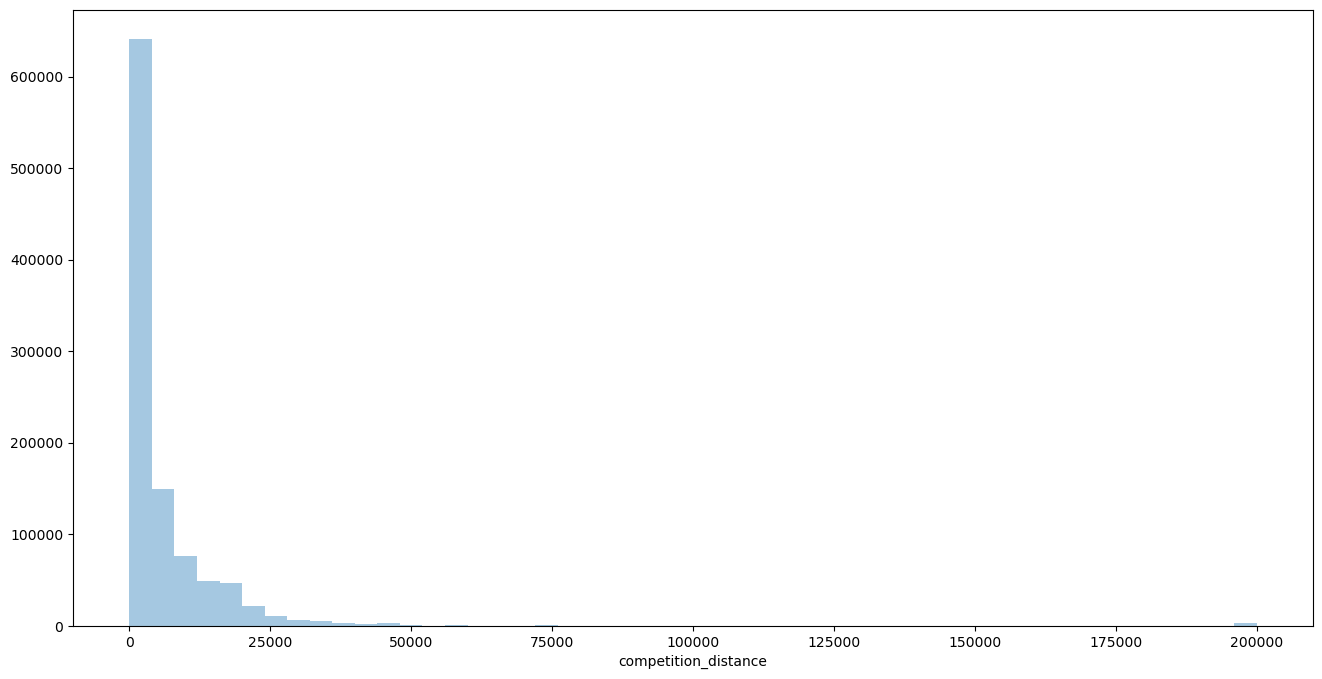

In [24]:
sns.distplot(df1['competition_distance'], kde=False)

### 1.7.2. Variáveis categóricas

In [25]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

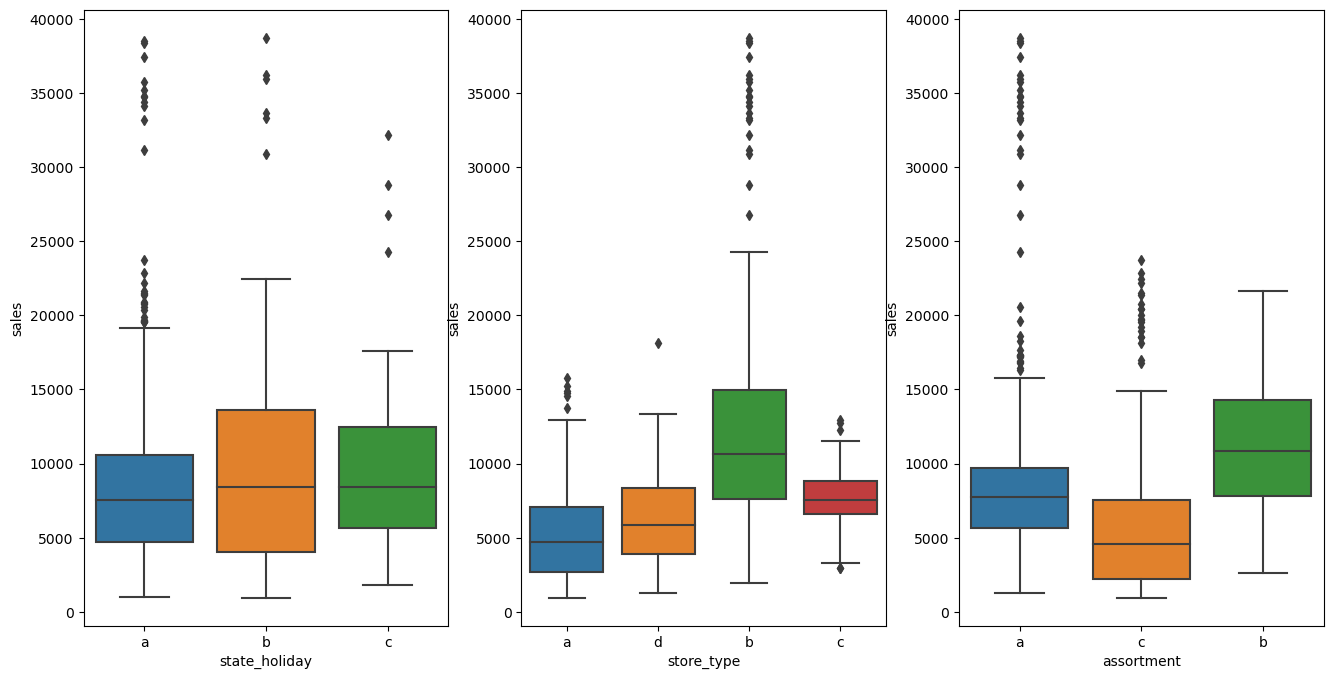

In [26]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux)

plt.show()

# 2.0 FEATURE ENGINEERING

In [27]:
# Definindo df2 como uma cópia de df1
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

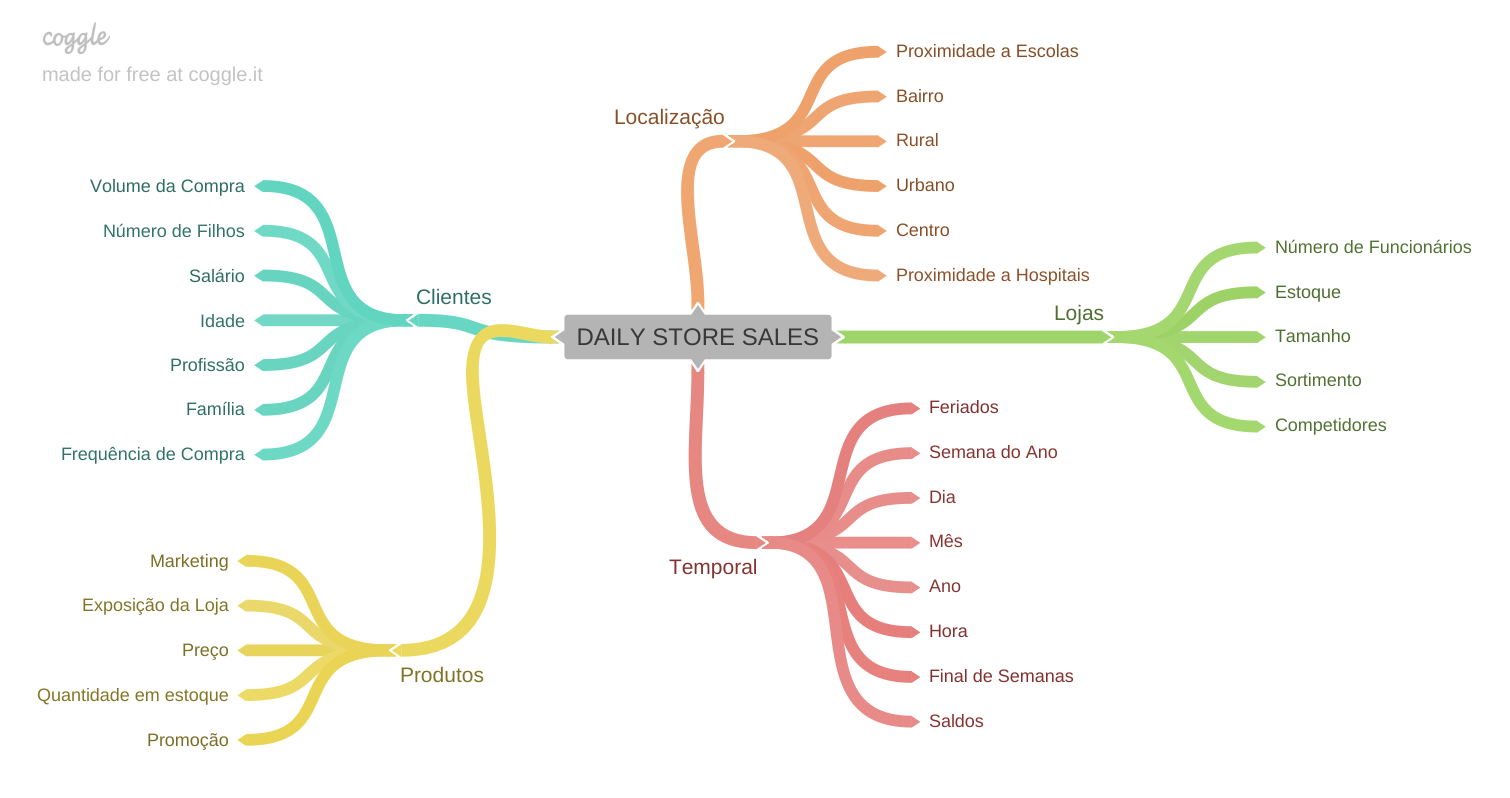

In [28]:
Image('img/MindMapHypotheses.png')

## 2.2 Criação das Hipóteses

<p align="justify">Inicialmente, serão apontadas diversas hipóteses que possam explicar o comportamento das vendas das lojas da Rossmann. Então, as hipóteses relevantes que podem ser descritas pelos dados disponíveis inicialmente serão indicadas em <strong>negrito</strong>. Caso seja necessária a aplicação de um novo ciclo do CRISP para melhorar os resultados das previsões, as hipóteses serão reavaliadas, sendo preciso talvez a captação de novas informções que agora não estão disponíveis.</p>

### 2.2.1 Hipóteses Loja

H1. Lojas com número maior de funcionários deveriam vender mais;<br/>
H2. Lojas com maior capacidade de estoque deveriam vender mais;<br/>
H3. Lojas com maior porte deveriam vender mais;<br/>
**H4. Lojas com maior sortimento deveriam vender mais;<br/>**
**H5. Lojas com competidores mais próximos deveriam vender menos;<br/>**
**H6. Lojas com competidores há mais tempo deveriam vender mais.**

### 2.2.2 Hipóteses Produto

H1. Lojas que investem mais em marketing deveriam vender mais;<br/>
H2. Lojas com maior sortimento deveriam vender mais;<br/>
H3. Lojas com produtos com preço menor deveriam vender mais;<br/>
H4. Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais;<br/>
**H5. Lojas com promoções ativas por mais tempo deveriam vender mais;<br/>**
**H6. Lojas com mais dias de promoção deveriam vender mais;<br/>**
**H7. Lojas com mais promoções consecutivas deveriam vender mais.**''

### 2.2.3 Hipóteses Tempo

**H1. Lojas abertas durante o feriado de Natal deveriam vender mais;<br/>**
**H2. Lojas deveriam vender mais ao longo dos anos;<br/>**
**H3. Lojas deveriam vender mais no segundo semestre do ano;<br/>**
**H4. Lojas deveriam vender mais depois do dia 10 de cada mês;<br/>**
**H5. Lojas deveriam vender menos aos finais de semana;<br/>**
**H6. Lojas deveriam vender menos durante os feriados escolares.**

## 2.3 Lista Final de Hipóteses

**H1.** Lojas com maior sortimentos deveriam vender mais;<br/>
**Falsa:** Lojas com **maior sortimento** vendem **menos**

**H2.** Lojas com competidores mais próximos deveriam vender menos;<br/>
**Falsa:** Lojas com **competidores mais próximos** vendem **mais**

**H3.** Lojas com competidores há mais tempo deveriam vender mais;<br/>
**Falsa:** Lojas com **competidores há mais tempo** vendem **menos**

**H4.** Lojas com promoções ativas por mais tempo deveriam vender mais;<br/>
**Falsa:** O efeito da promoção é positivo até certo ponto, **próximo aos valores mais altos** dos períodos de promoção **as vendas caem**

**H5.** Lojas com mais dias de promoção deveriam vender mais;<br/>
A hipótese será validada no próximo ciclo do CRISP

**H6.** Lojas com mais promoções consecutivas deveriam vender mais;<br/>
**Falsa:** Lojas com mais promoções consecutivas vendem **menos**

**H7.** Lojas abertas durante o feriado de Natal deveriam vender mais;<br/>
**Falsa:** Lojas abertas durante o **feriado de Natal** vendem **menos** em relação aos outros feriados

**H8.** Lojas deveriam vender mais ao longo dos anos;<br/>
**Falsa:** As lojas estão vendendo **menos** ao longo dos anos

**H9.** Lojas deveriam vender mais no segundo semestre do ano;<br/>
**Verdadeira:** As lojas estão vendendo **mais** no **segundo semestre** do ano

**H10.** Lojas deveriam vender mais depois do dia 10 de cada mês;<br/>
**Falsa:** Lojas **vendem menos em média depois do dia 10** de cada mês

**H11.** Lojas deveriam vender menos aos finais de semana;<br/>
**Verdadeira:** Lojas **vendem menos** aos **finais de semana**

**H12.** Lojas deveriam vender menos durante os feriados escolares.<br/>
**Verdadeira:** Lojas vendem **menos** durante os **feriados escolares**. Porém, nos meses de julho e agosto as vendas em feriados escolares são equiparáveis e maiores, respectivamente, que as vendas em dias sem feriados escolares, pois nesses meses ocorrem as férias escolares de verão.

## 2.4 Feature Engineering

In [29]:
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo'],
      dtype='object')

In [30]:
# Coluna year
df2['year'] = df2['date'].dt.year

# Coluna month
df2['month'] = df2['date'].dt.month

# Coluna day
df2['day'] = df2['date'].dt.day

# Coluna week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# Coluna year-week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# Colunas competition
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


# Colunas promo
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# Coluna assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# Coluna state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 FILTRAGEM DE VARIÁVEIS

In [31]:
# Definindo df3 como uma cópia de df2
df3 = df2.copy()

In [32]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### 3.1 Filtragem das linhas

In [33]:
# Filtrando o dataframe deixando apenas lojas abertas ('open' ≠ 0) e que possuem vendas ('sales' > 0)
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.1 Seleção das colunas

In [34]:
# Excluindo as colunas 'customers', 'open', 'promo_interval' e 'month_map'. Essas colunas não são essenciais
# para o modelo
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(columns=cols_drop, axis=1)

# 4.0 ANÁLISE EXPLORATÓRIA DE DADOS

In [35]:
# Definindo df4 como uma cópia de df3
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Variável resposta

<AxesSubplot:xlabel='sales'>

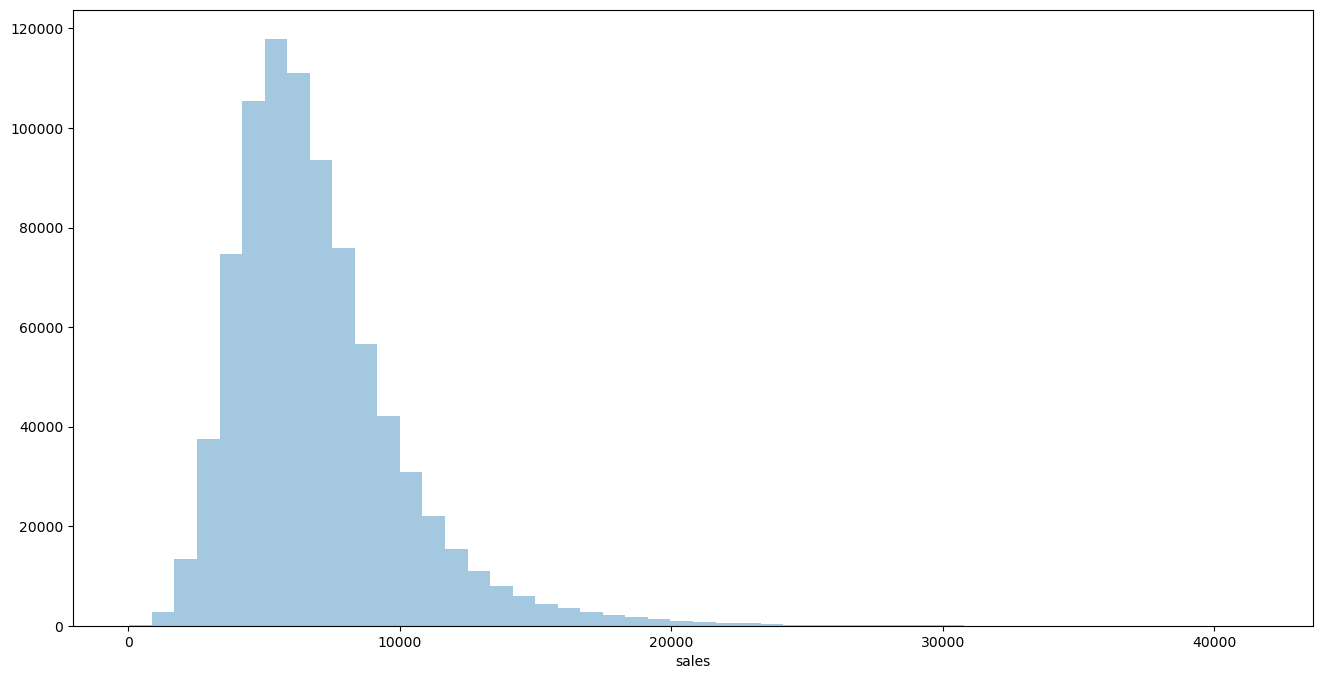

In [36]:
# Histograma da variável 'sales'
sns.distplot(df4['sales'], kde=False)

### 4.1.2 Variáveis numéricas

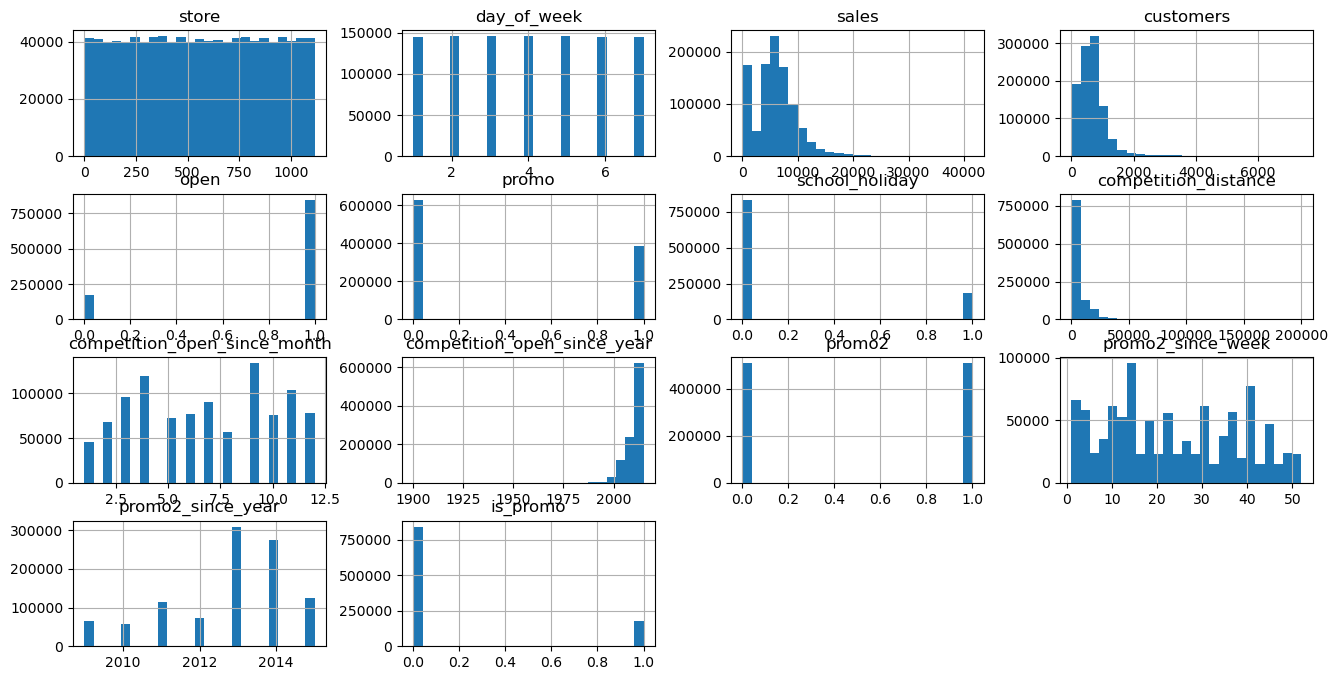

In [37]:
# Distribuições das variáveis numéricas
num_attributes.hist(bins=25)
plt.show()

### 4.1.3 Variáveis categóricas

In [38]:
# Valores da variável 'assortment'
df4['assortment'].unique()

array(['basic', 'extended', 'extra'], dtype=object)

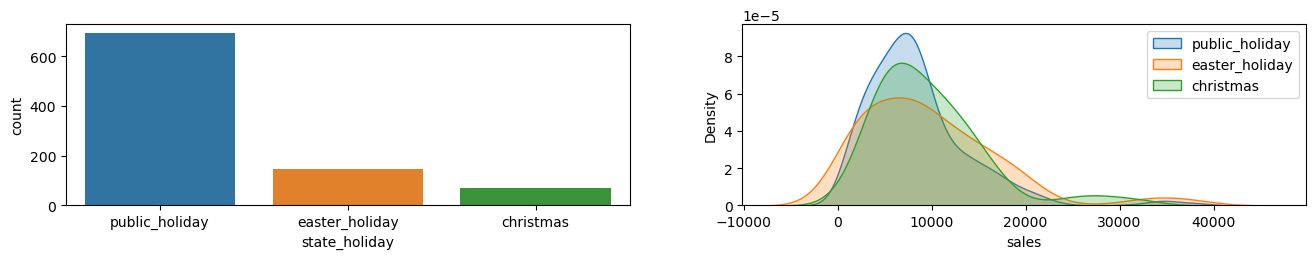

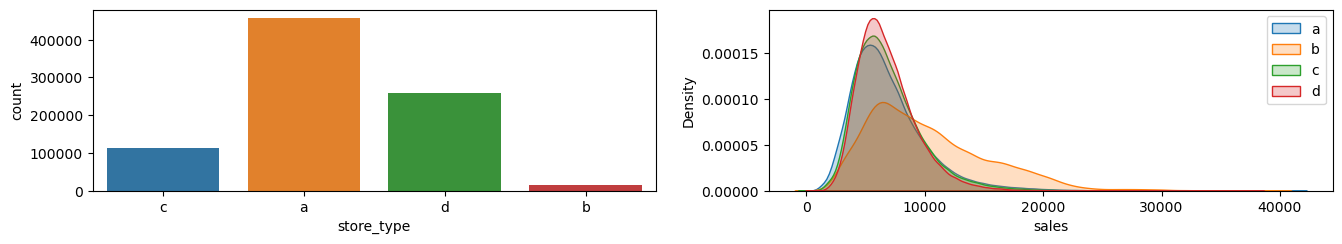

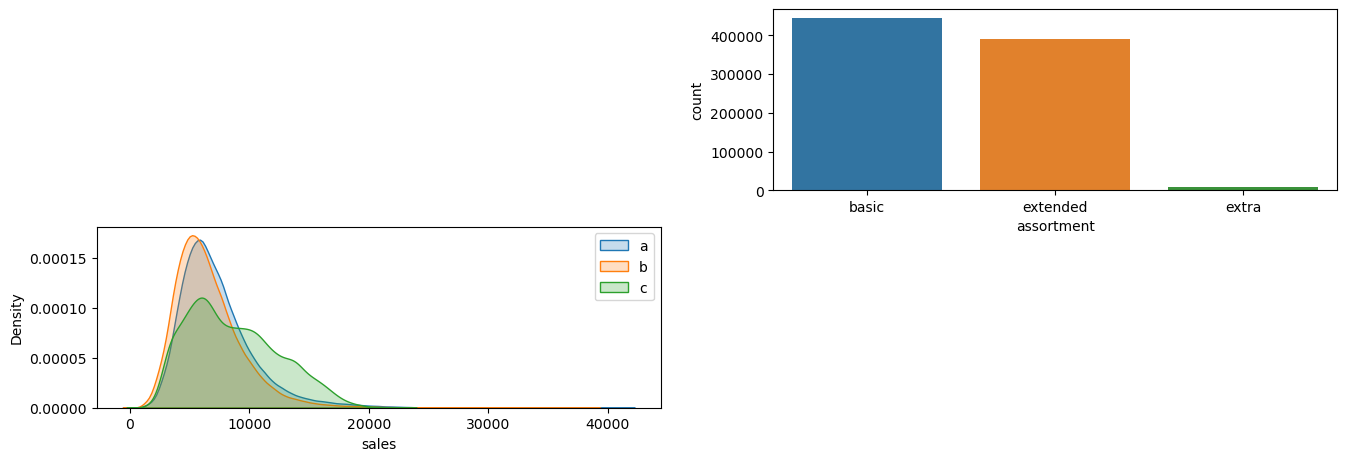

In [39]:
# Distribuições das variáveis 'store_holiday', 'store_type' e 'assortment'

# store_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(data=df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(data=df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(data=df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
plt.legend()
plt.show()

# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

plt.legend()
plt.show()

# assortment
plt.subplot(3, 2, 4)

sns.countplot(df4['assortment'])

plt.subplot(3, 2, 5)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='c', shade=True)

plt.legend()
plt.show()

## 4.2 Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais
**Falsa:** Lojas com **maior sortimento** vendem **menos**

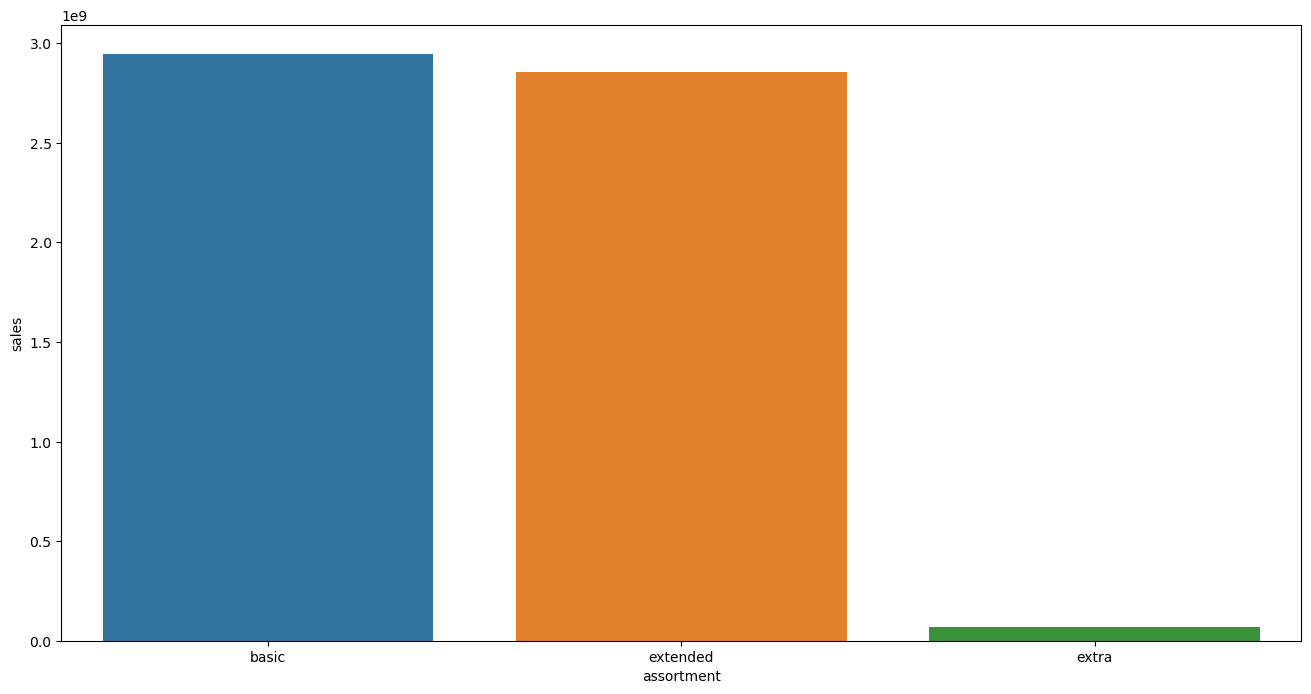

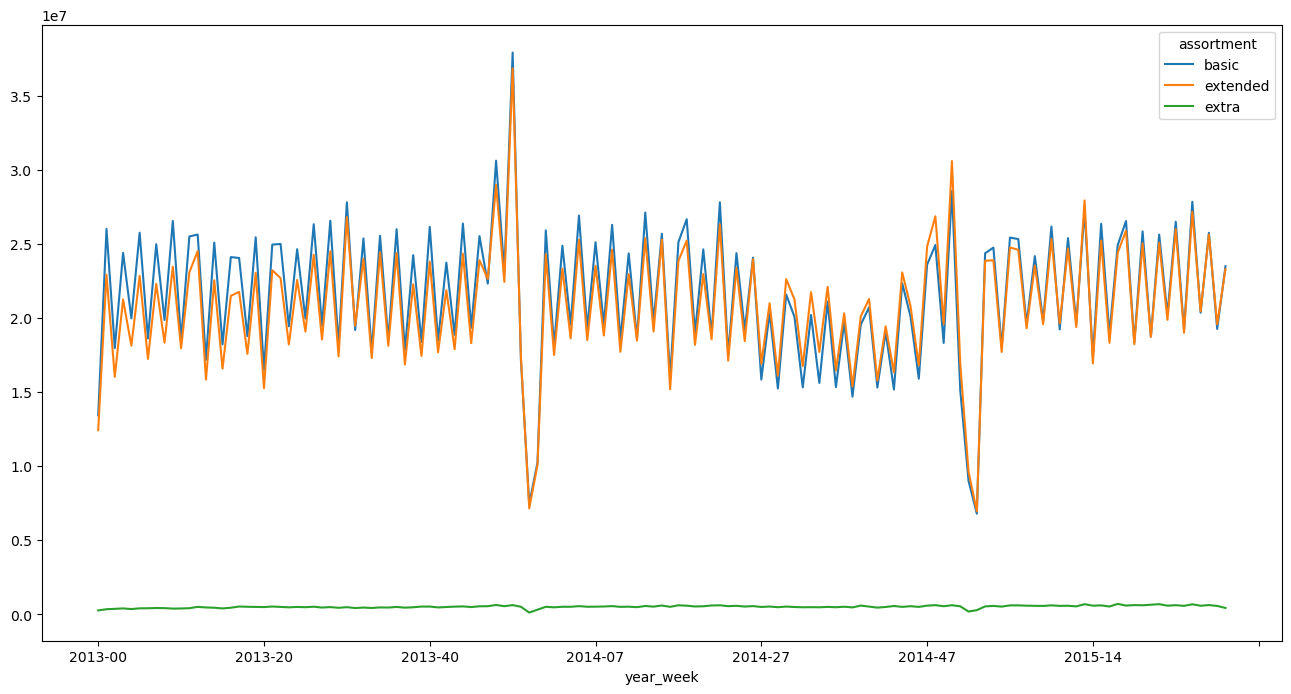

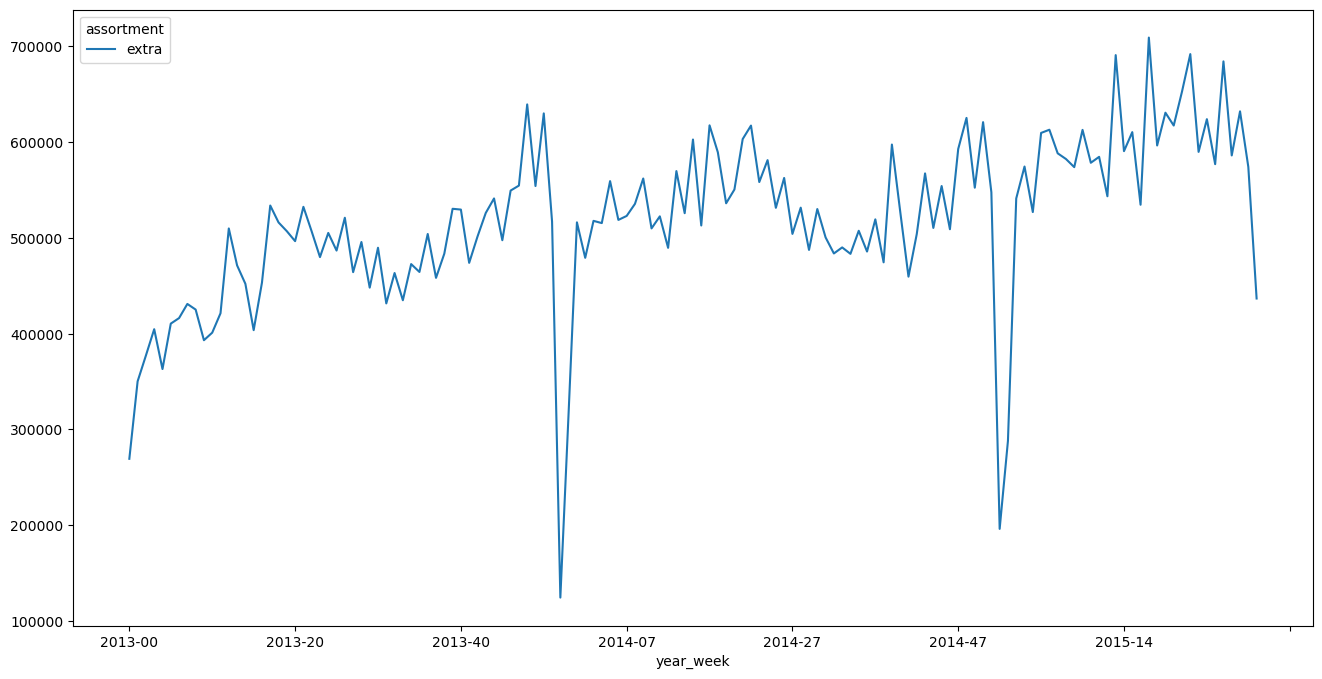

In [40]:
aux1 = df4[['assortment', 'sales']].groupby(by='assortment').sum().reset_index()
sns.barplot(data=aux1, x='assortment', y='sales');

aux2 = df4[['assortment', 'year_week', 'sales']].groupby(by=['year_week', 'assortment']).sum().reset_index()
aux3 = aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux2[aux2['assortment'] == 'extra'].pivot(index='year_week', columns='assortment', values='sales').plot()

plt.show()

### H2. Lojas com competidores mais próximos deveriam vender menos
**Falsa:** Lojas com **competidores mais próximos** vendem **mais**

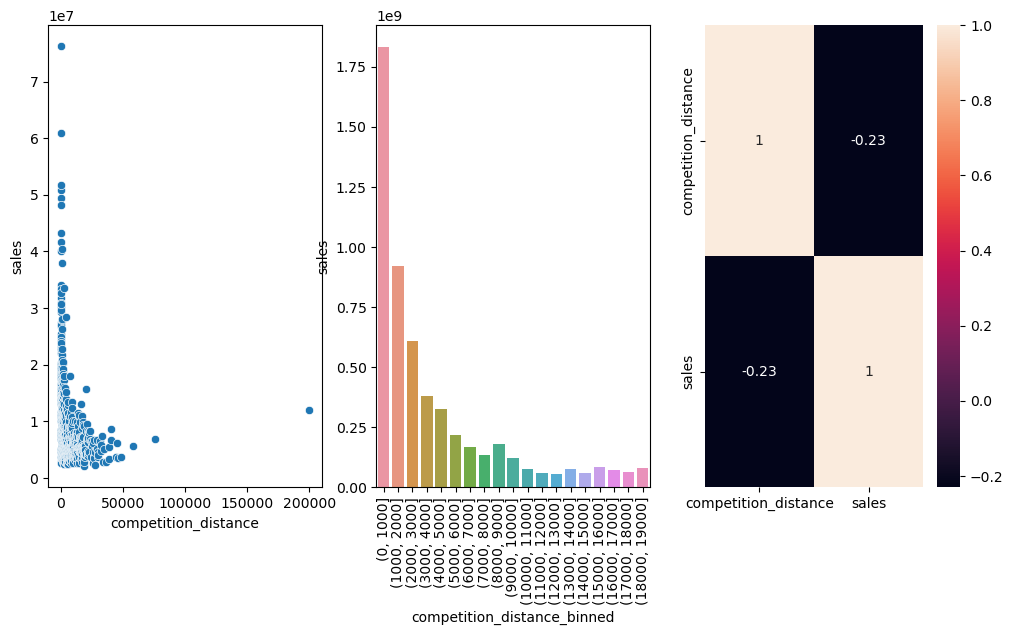

In [187]:
plt.figure(figsize=(12, 6))

aux1 = df4[['competition_distance', 'sales']].groupby(by='competition_distance').sum().reset_index()
plt.subplot(1, 3, 1)
sns.scatterplot(data=aux1, x='competition_distance', y='sales')

bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby(by='competition_distance_binned').sum().reset_index()

plt.subplot(1, 3, 2)
sns.barplot(data=aux2, x='competition_distance_binned', y='sales');
plt.xticks(rotation='90')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

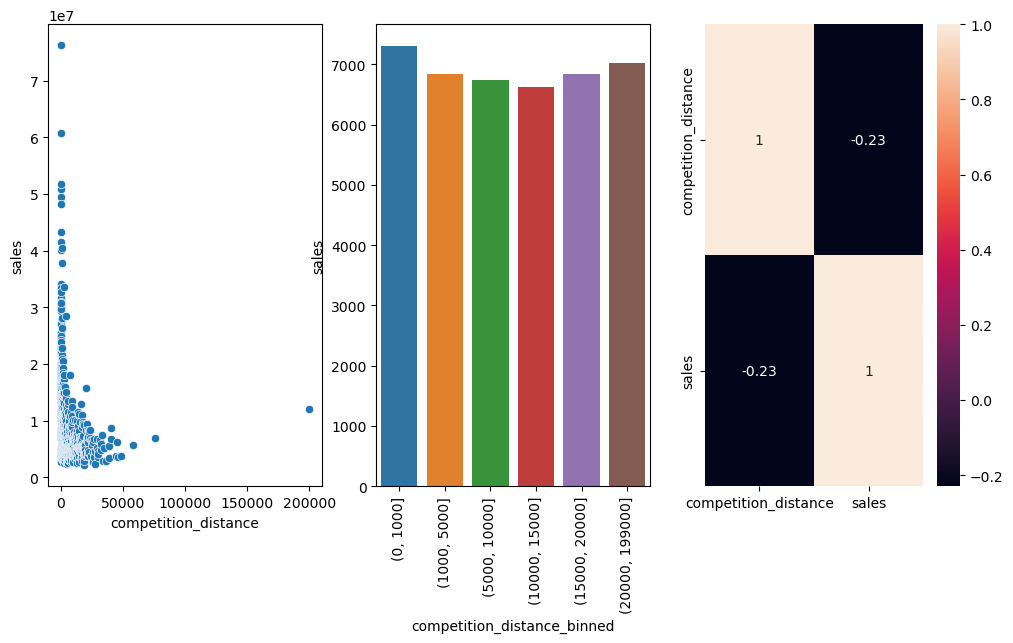

In [228]:
plt.figure(figsize=(12, 6))

aux1 = df4[['store', 'competition_distance', 'sales']]
aux2 = df4[['competition_distance', 'sales']].groupby(by='competition_distance').sum().reset_index()
plt.subplot(1, 3, 1)
sns.scatterplot(data=aux2, x='competition_distance', y='sales')

# bins = list(np.arange(0, 20000, 1000))
bins = [0, 1000, 5000, 10000, 15000, 20000, 199000]
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux3 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()

plt.subplot(1, 3, 2)
sns.barplot(data=aux3, x='competition_distance_binned', y='sales');
plt.xticks(rotation='90')

plt.subplot(1, 3, 3)
sns.heatmap(aux2.corr(method='pearson'), annot=True);

As lojas com competidor mais próximo até 1 km possuem vendas 4% a 9% maiores que as faixas de maiores distâncias

### H3. Lojas com competidores há mais tempo deveriam vender mais
**Falsa:** Lojas com **competidores há mais tempo** vendem **menos**

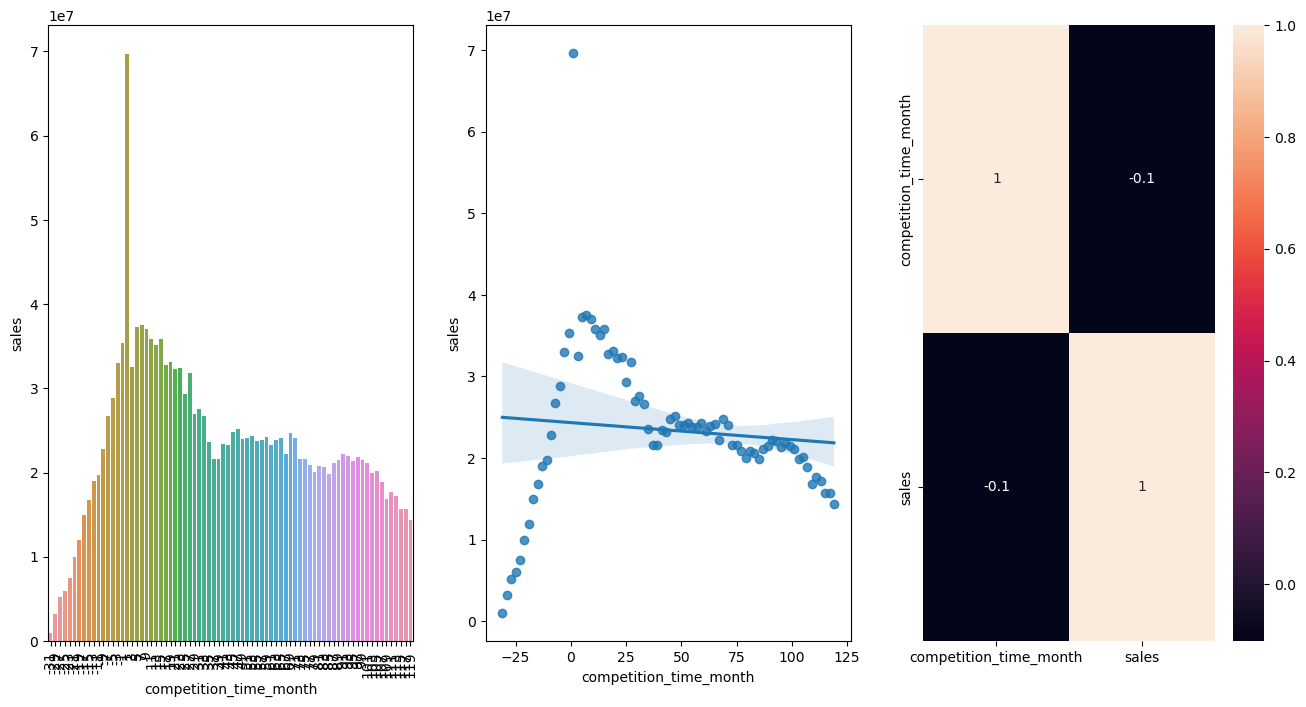

In [42]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & aux1['competition_time_month'] != 0]

plt.subplot(1, 3, 1)
sns.barplot(data=aux2, x='competition_time_month', y='sales');
plt.xticks(rotation='90');

plt.subplot(1, 3, 2)
sns.regplot(data=aux2, x='competition_time_month', y='sales');

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais
**Falsa:** O efeito da promoção é positivo até certo ponto, **próximo aos valores mais altos** dos períodos de promoção **as vendas caem**

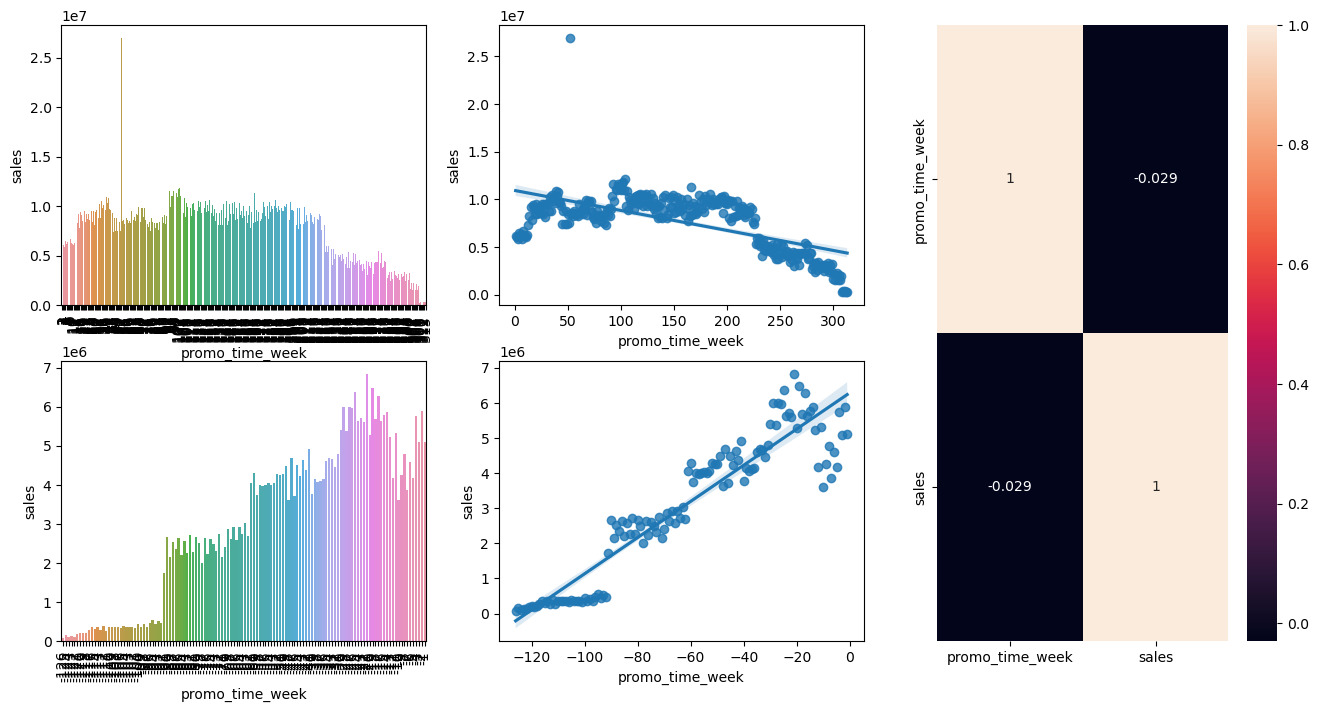

In [43]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
aux2 = aux1[aux1['promo_time_week'] > 0] # período estendido
aux3 = aux1[aux1['promo_time_week'] < 0] # promoção regular

grid = plt.GridSpec(2, 3)

plt.subplot(grid[0,0])
sns.barplot(data=aux2, x='promo_time_week', y='sales');
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(data=aux2, x='promo_time_week', y='sales');

plt.subplot(grid[1,0])
sns.barplot(data=aux3, x='promo_time_week', y='sales');
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(data=aux3, x='promo_time_week', y='sales');

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.show()

### <s>H5. Lojas com mais dias de promoção deveriam vender mais</s> 
A hipótese será validada no próximo ciclo do CRISP

### H6. Lojas com mais promoções consecutivas deveriam vender mais
**Falsa:** Lojas com mais promoções consecutivas vendem **menos**

In [44]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values('sales', ascending=True)

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


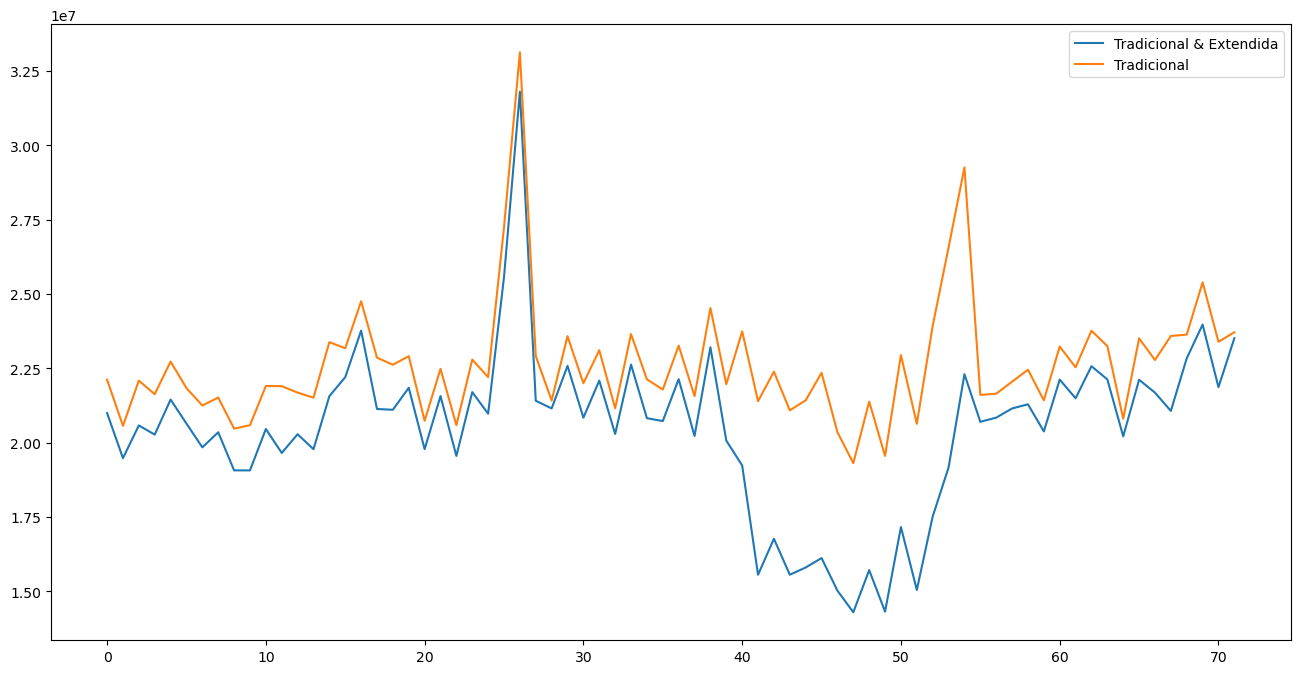

In [45]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']]\
                                                      .groupby('year_week').sum().reset_index()

ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']]\
                                                      .groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

ax.legend(labels=['Tradicional & Extendida', 'Tradicional']);
plt.show()

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**Falsa:** Lojas abertas durante o **feriado de Natal** vendem em média **menos** em relação ao feriado de páscoa e **mais** que os outros feriados regulares. Em 2014 o feriado de Natal **superou** as vendas médias dos feriados regulares.

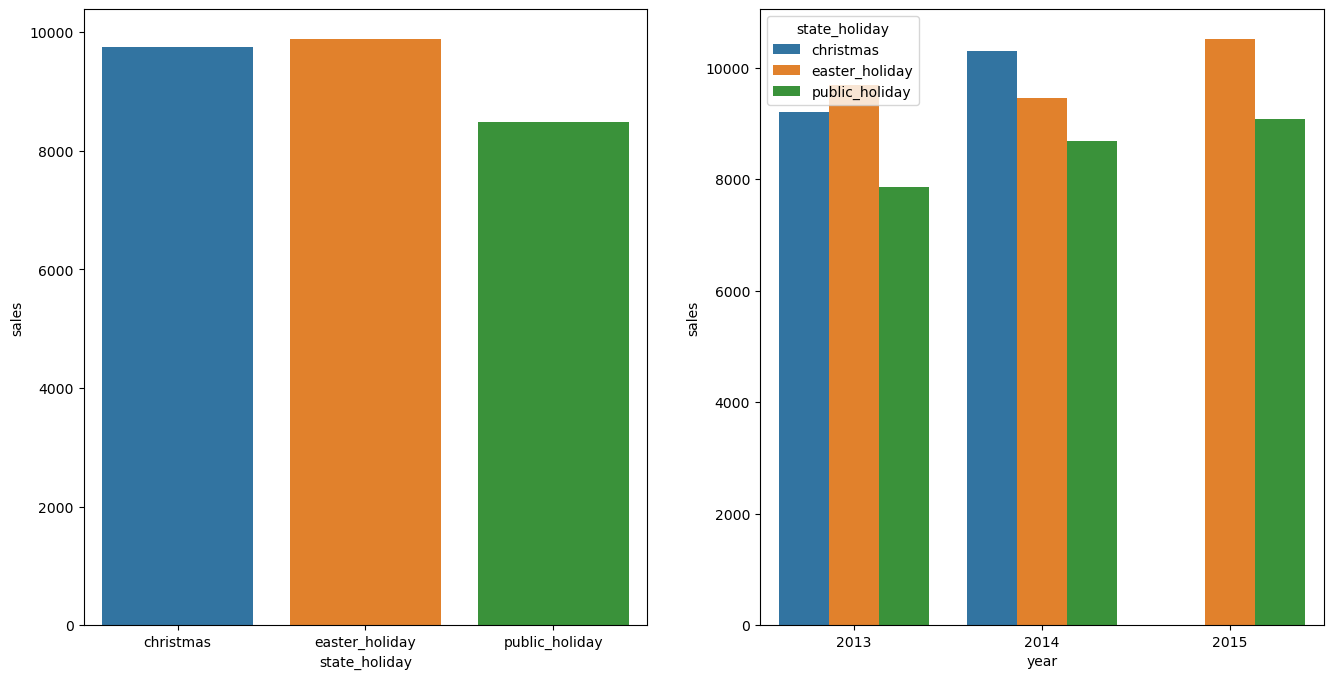

In [240]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### H8. Lojas deveriam vender mais ao longo dos anos
**Falsa:** As lojas estão vendendo **menos** ao longo dos anos

Como o ano de 2015 não está completo, pois seus dados vão até o mês de julho, a primeira comparação é entre os anos de 2013 e 2014:

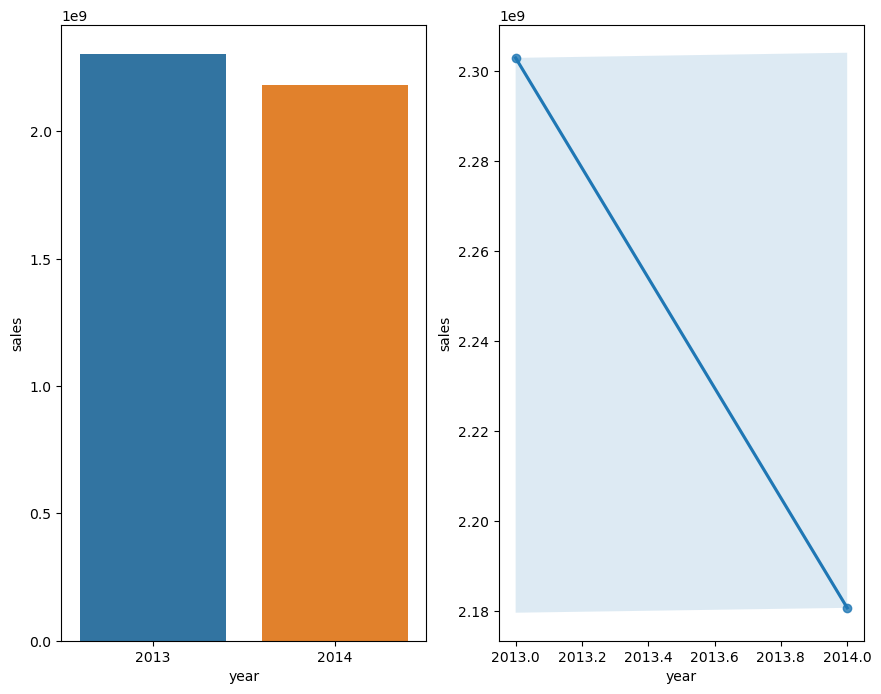

In [169]:
aux1 = df4[df4['year'] < 2015][['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

As vendas totais do ano de 2014 foram aproximadamente 5,3% menores que as de 2013.
Para incluir o ano de 2015 na análise, observa-se a média mensal de vendas em cada um dos anos:

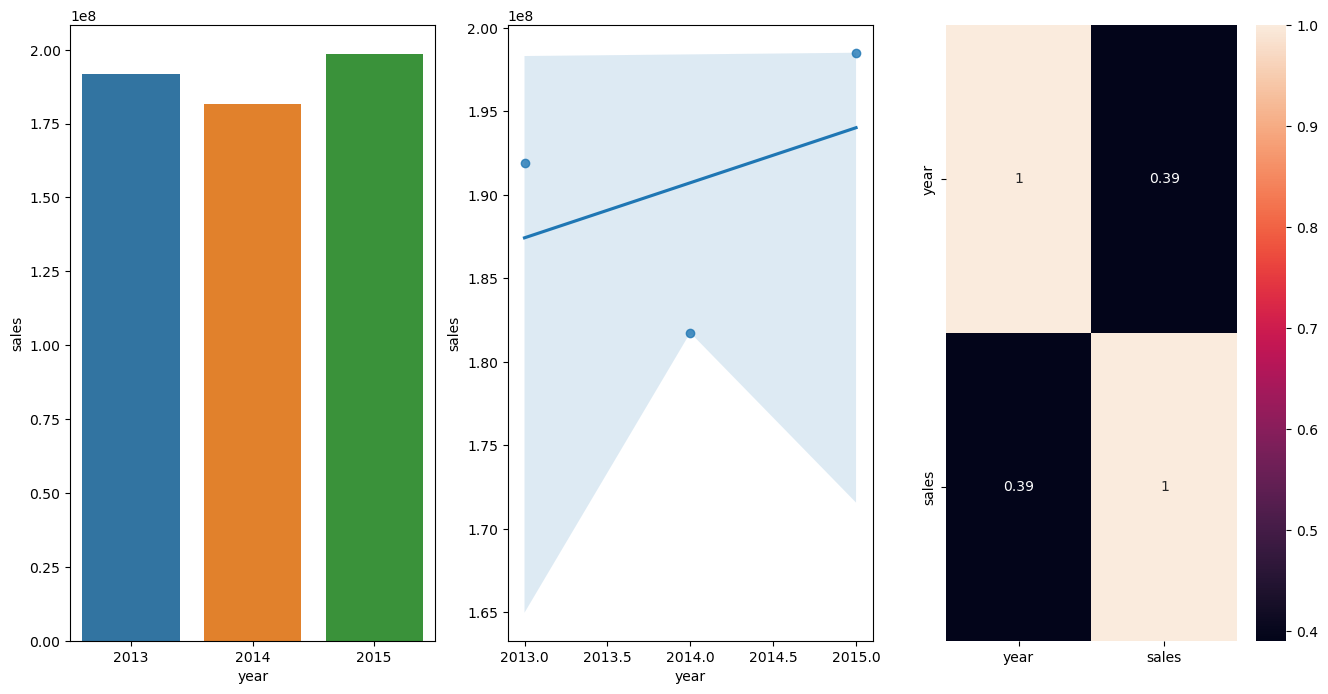

In [162]:
aux2 = df4[['month', 'year', 'sales']].groupby(['year', 'month']).sum().groupby('year').mean().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux2);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux2.corr(method='pearson'), annot=True);

Neste cenário, há recuperação neste parâmetro no mês de 2015, apresentando uma venda mensal média 9,2% maior que o ano anterior.

### H9. Lojas deveriam vender mais no segundo semestre do ano
**Verdadeira:** As lojas estão vendendo **mais** no **segundo semestre** do ano

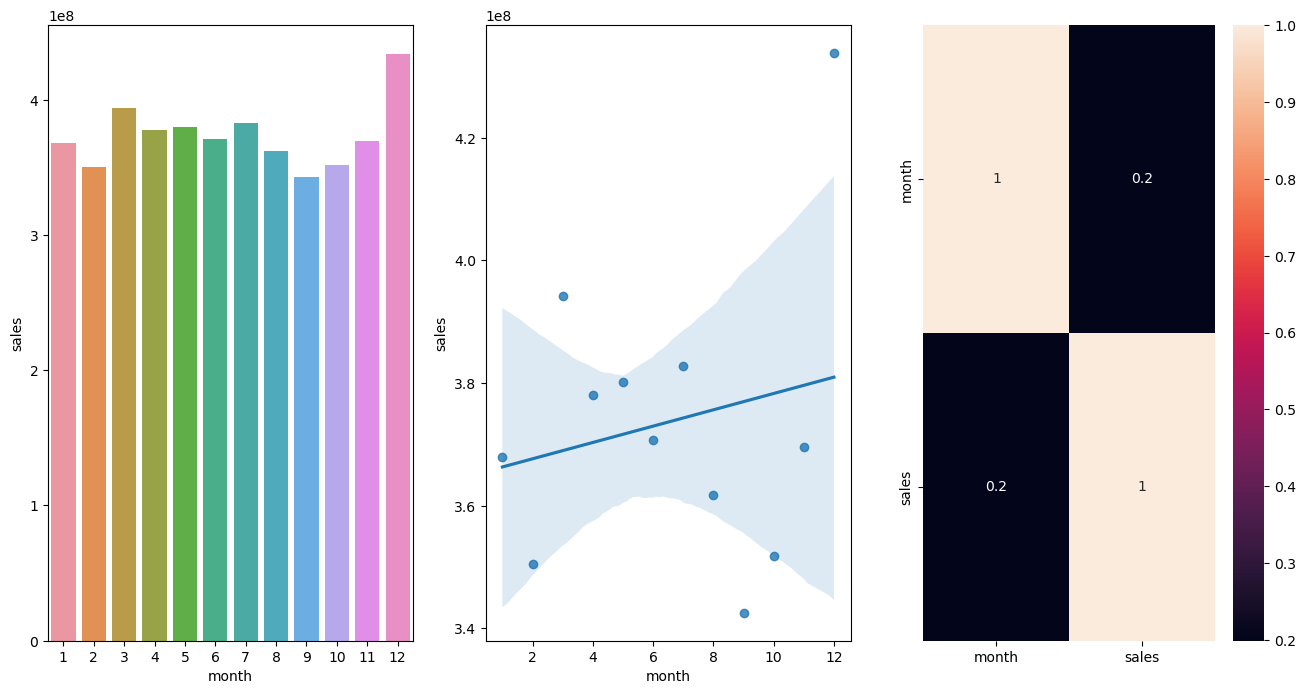

In [246]:
aux1 = df4[df4['year'] < 2015][['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

###  H10. Lojas deveriam vender mais depois do dia 10 de cada mês
**Falsa:** Lojas **vendem menos em média depois do dia 10** de cada mês

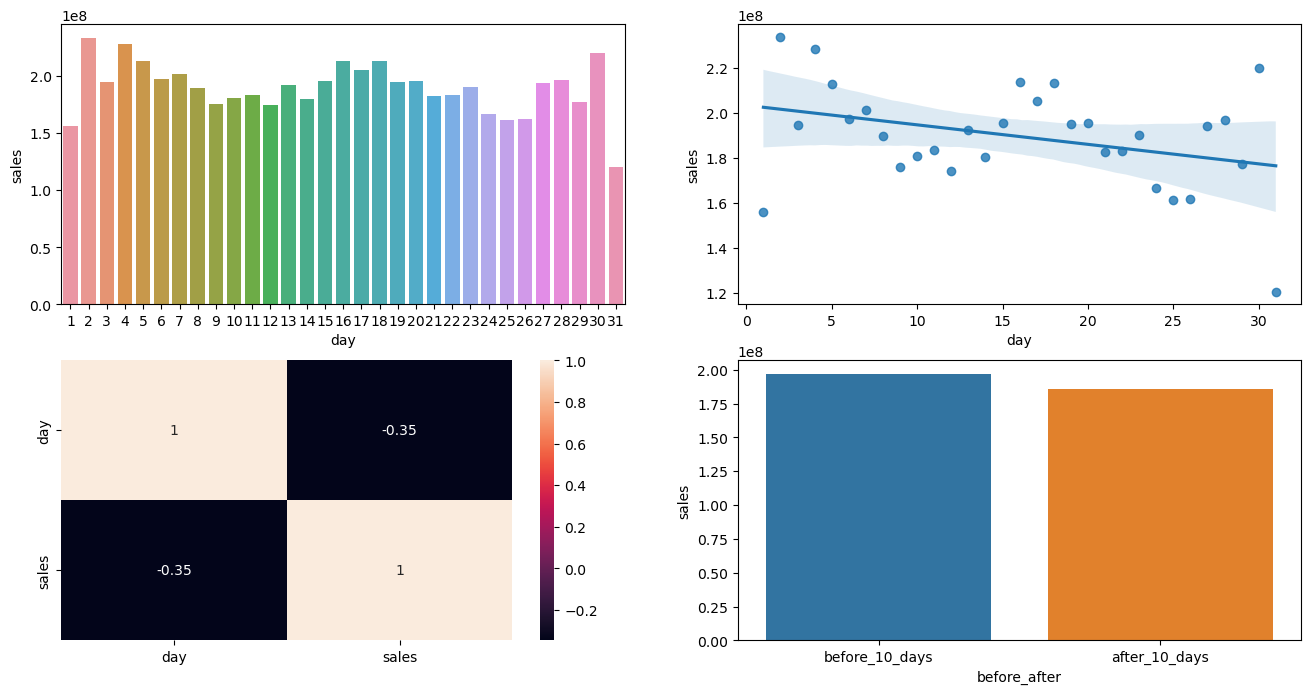

In [270]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 =aux1[['before_after', 'sales']].groupby('before_after').mean().reset_index().sort_values('before_after', ascending=False)

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2);

### H11. Lojas deveriam vender menos aos finais de semana
**Verdadeira:** Lojas **vendem menos** aos **finais de semana**

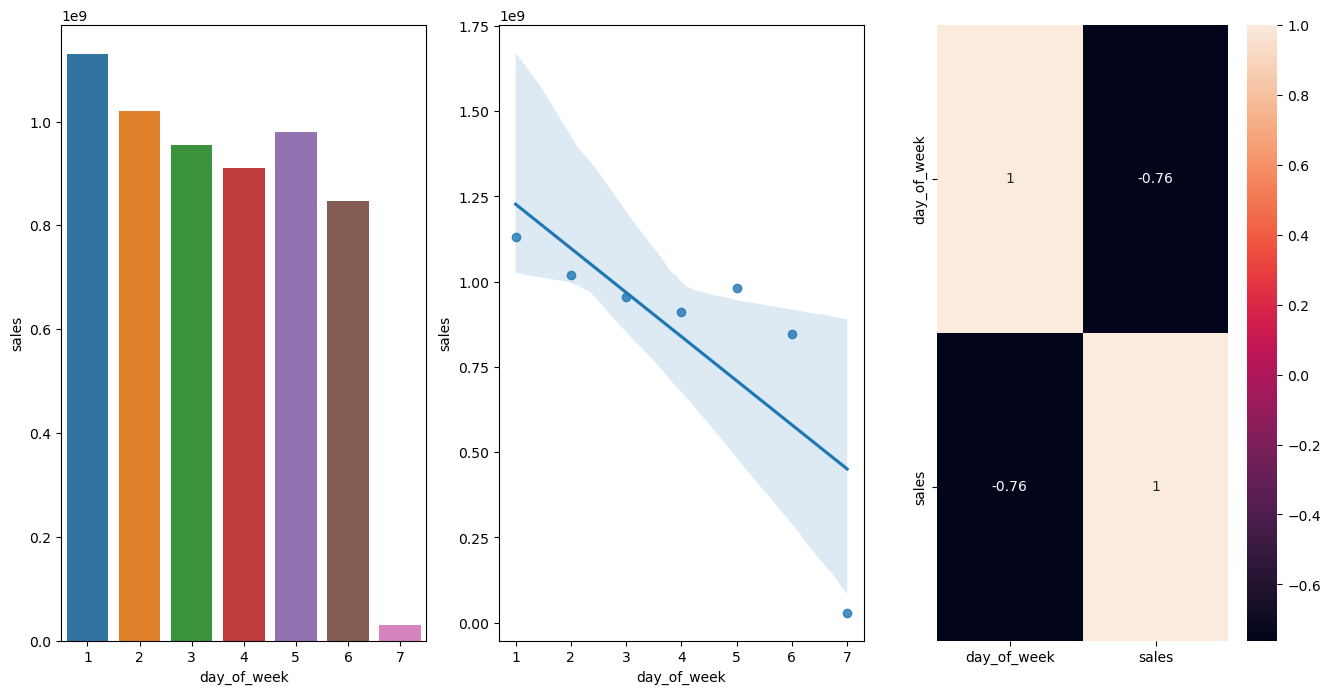

In [50]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot( x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12. Lojas deveriam vender menos durante os feriados escolares.
**Verdadeira:** Lojas vendem **menos** durante os **feriados escolares**. Porém, nos meses de julho e agosto as vendas em feriados escolares são equiparáveis e maiores, respectivamente, que as vendas em dias sem feriados escolares, pois nesses meses ocorrem as férias escolares de verão.

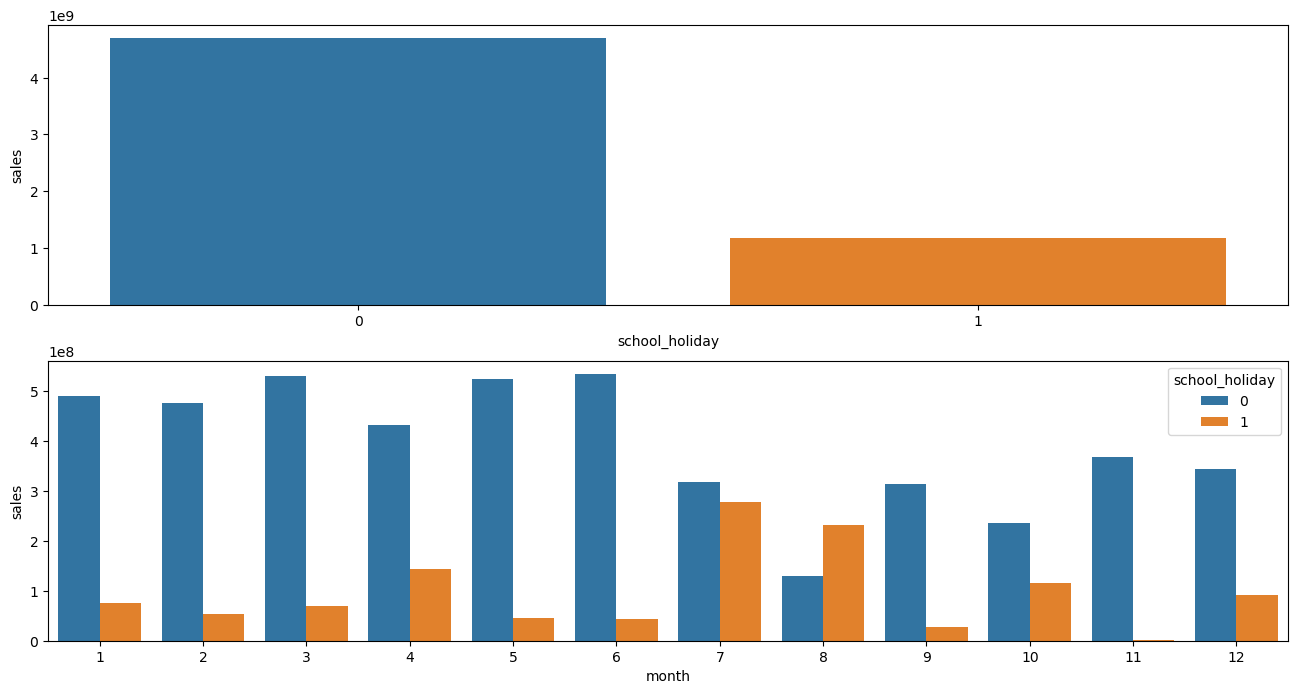

In [51]:
plt.subplot(2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(data=aux1, x='school_holiday', y='sales');

plt.subplot(2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(data=aux2, x='month', y='sales', hue='school_holiday');

### 4.2.1 Resumo das hipóteses

In [52]:
tab =[['Hipóteses', 'Conclusão', 'Relevância'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Verdadeira', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
     ]  
print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1 Variáveis numéricas

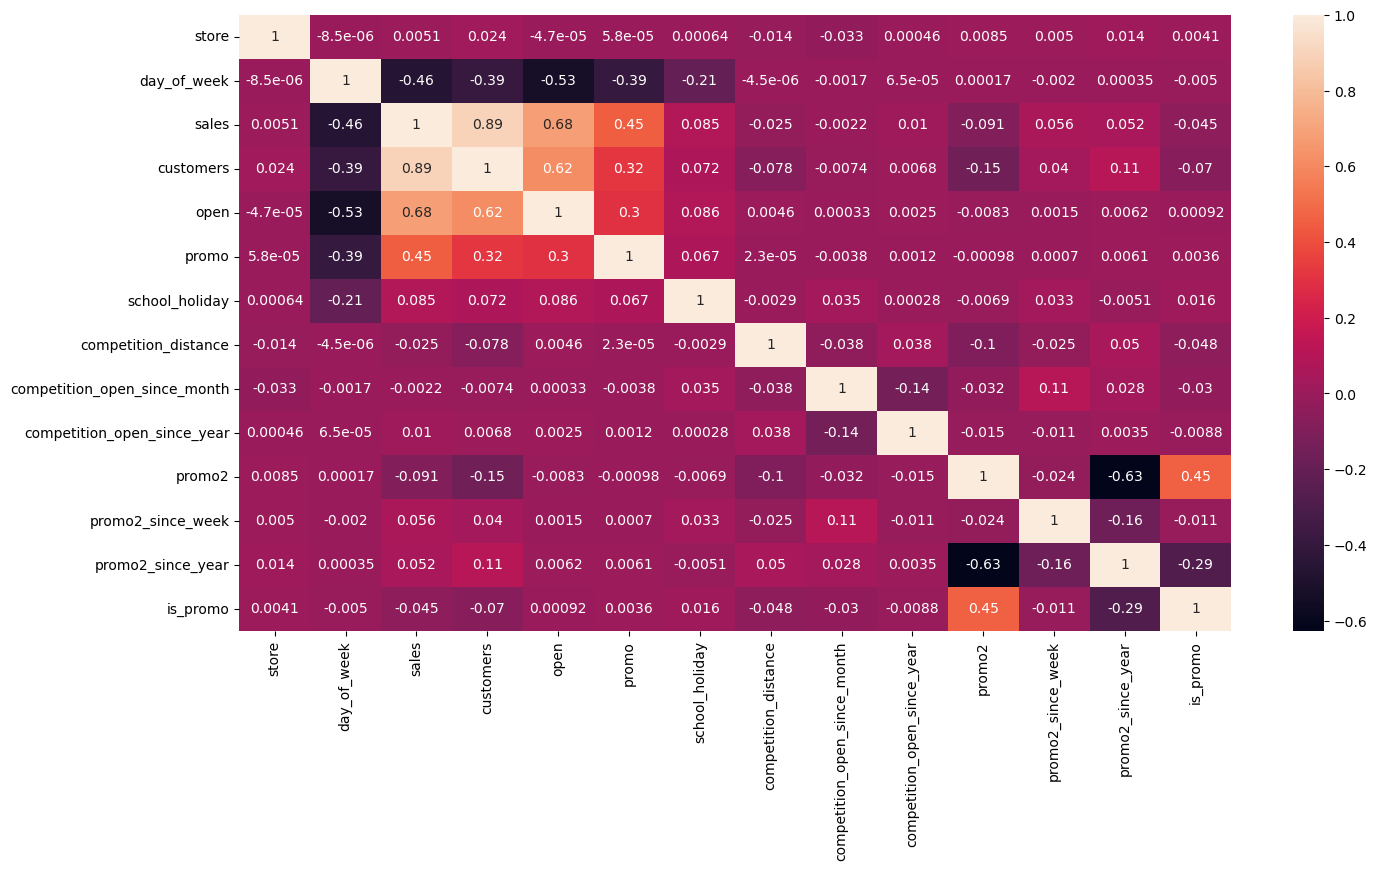

In [53]:
# Correlações entre as variáveis numéricas
correlation = num_attributes.corr(method='pearson')

sns.heatmap(correlation, annot=True);

### 4.3.2 Variáveis categóricas

In [54]:
# Selecionando as variáveis categóricas
a = df4.select_dtypes(include='object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [55]:
cm = pd.crosstab(a['state_holiday'], a['store_type']).values
cm

array([[     4,     66,      0,      1],
       [    36,    100,      0,      9],
       [   236,    285,     65,    108],
       [456766,  15109, 112903, 258650]])

In [56]:
# Calculando as correlações por meio da funcção pycorr.corr()
print('without bias correction:', pycorr.corr(a['state_holiday'], a['store_type'], bias_correction=False))
print('with bias correction:   ', pycorr.corr(a['state_holiday'], a['store_type'], bias_correction=True))

without bias correction: 0.07106457093267678
with bias correction:    0.071039693758565


In [57]:
# Calculando as correlações usando a função V de Cramér
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]})
d = d.set_index(d.columns)
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


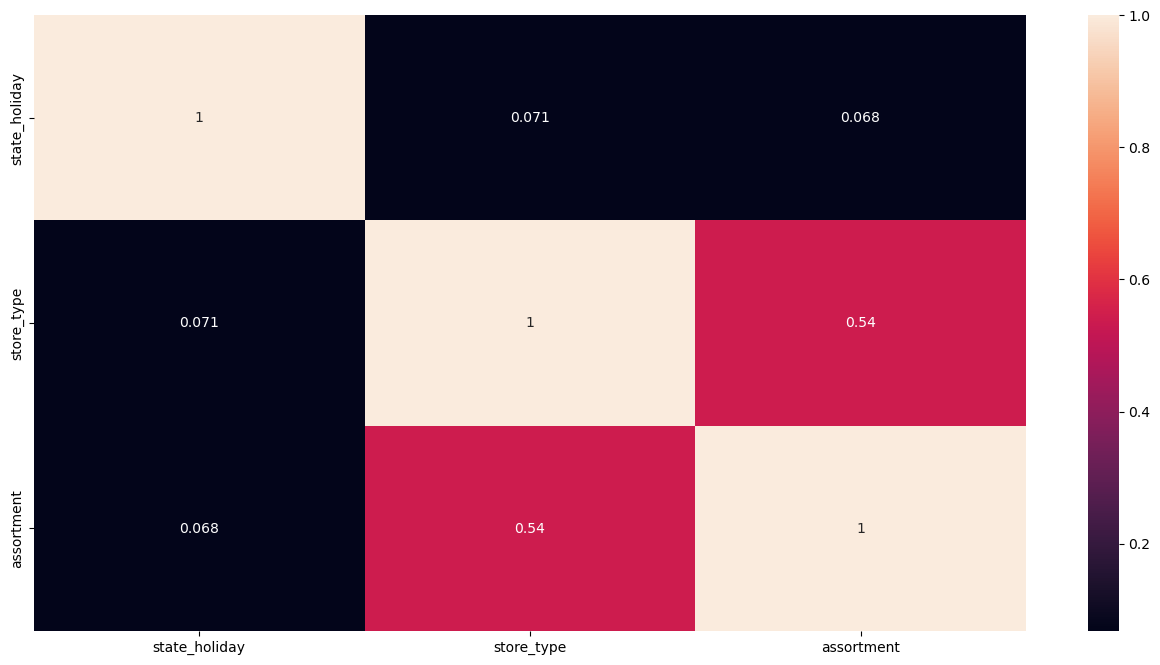

In [58]:
sns.heatmap(d, annot=True);

# 5.0 PREPARAÇÃO DOS DADOS

In [59]:
# Definindo df5 como uma cópia de df4
df5 = df4.copy()

In [60]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 5.1 Normalização

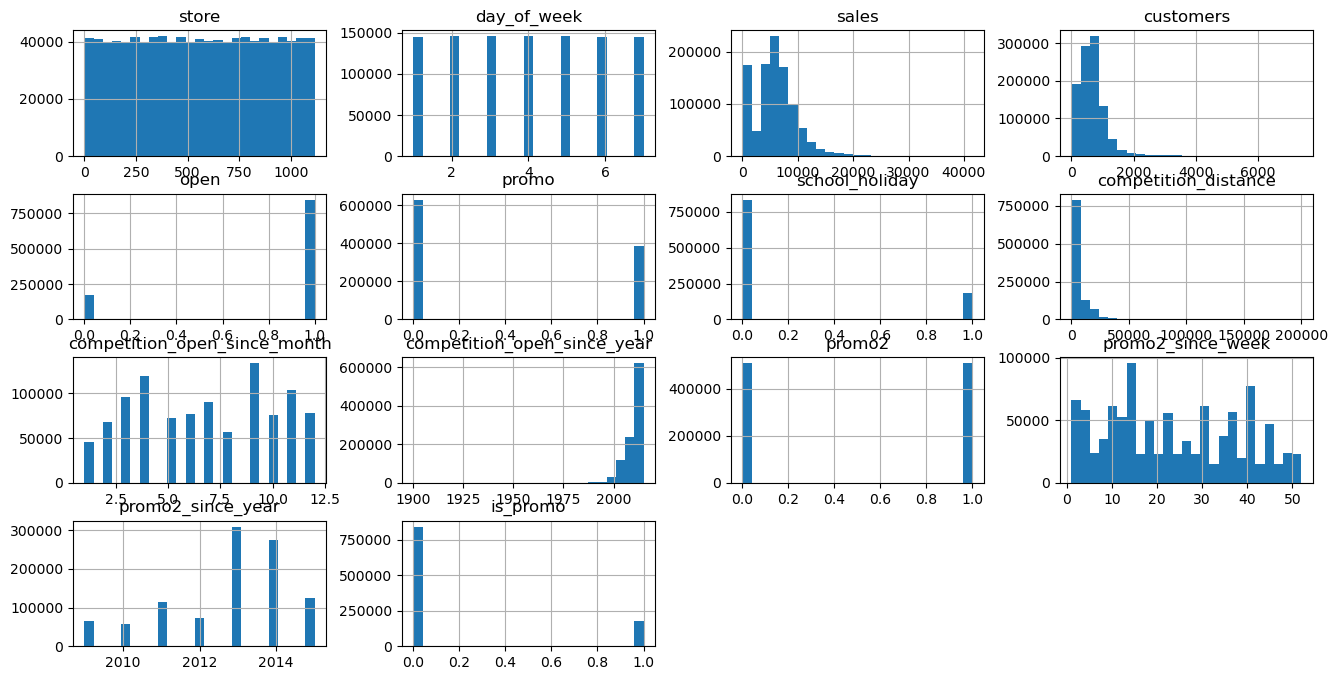

In [61]:
num_attributes.hist(bins=25)
plt.show()

<strong>Não há variável que possui distribuição normal, então aqui não cabe normalização.</strong>

## 5.2 Rescaling

In [62]:
# Instanciando os métodos de rescaling
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
# pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
# pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
# pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
# pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

## 5.3 Transformação

### 5.3.1 Encoding

In [63]:
# Coluna state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# Coluna store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
# pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

# Coluna assortment - Ordinal Encoding
assortment_dict = {'basic': 1,
                   'extra': 2, 
                   'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Transformação da variável resposta

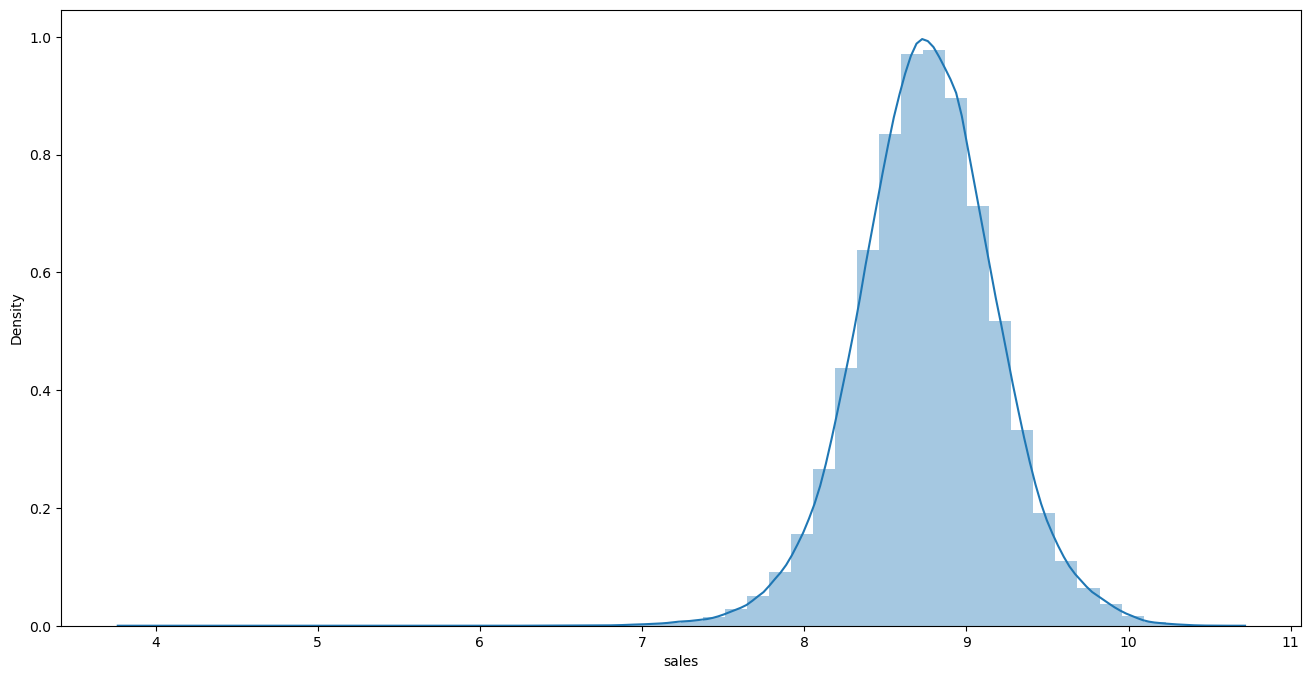

In [64]:
# Aplicação do logaritmo natural (acrescido de 1 para tratar possíveis zeros) na variável 'sales'
df5['sales'] = np.log1p(df5['sales'])
sns.distplot(df5['sales']);

### 5.3.2 Transformação de natureza

In [65]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


In [66]:
# Variáveis cíclicas

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x :np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x :np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x :np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x :np.cos(x * (2. * np.pi/12)))


# day
df5['day_sin'] = df5['day'].apply(lambda x :np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x :np.cos(x * (2. * np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x :np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x :np.cos(x * (2. * np.pi/52)))

# 6.0 SELEÇÃO DE ATRIBUTOS

In [67]:
# Definindo df5 como uma cópia de df5
df6 = df5.copy()

## 6.1 Separação do dataframe em dados de treino e de teste para o método Boruta de seleção de atributos

In [68]:
# Removendo as colunas 'week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 
# 'competition_since' e 'year_week'
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [69]:
# Obtendo a data em que começam as últimas 6 semanas do conjunto de dados
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [70]:
# Separando os dados de treino e teste. Os dados de treino serão aqueles do início da série temporal até
# o limite inferior das últimas 6 semanas. Os dados de teste contarão com as últimas 6 semanas dos dados.

# dados de treino
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# dados de teste
# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Treino - Data mínima: {}'.format(X_train['date'].min()))
print('Treino - Data máxima: {}'.format(X_train['date'].max()))

print('\nTeste - Data mínima: {}'.format(X_test['date'].min()))
print('Teste - Data máxima: {}'.format(X_test['date'].max()))

Treino - Data mínima: 2013-01-01 00:00:00
Treino - Data máxima: 2015-06-18 00:00:00

Teste - Data mínima: 2015-06-19 00:00:00
Teste - Data máxima: 2015-07-31 00:00:00


## 6.2 Boruta como seletor de atributos

In [71]:
# # dados de treino e teste para Boruta
# X_train_n = X_train.drop(columns=['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# # definindo RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# # definindo Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 Melhores atributos para o Boruta

In [72]:
# cols_selected = boruta.support_.tolist()

# # melhores atributos
# X_train_fs = X_train.drop(columns=['date', 'sales'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # colunas não selecionadas
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [73]:
# cols_selected_boruta

In [74]:
# cols_not_selected_boruta

## 6.3 Seleção manual de atributos

In [75]:
# Pelo método Boruta demorar para rodar, após a primeira execução as colunas foram selecionadas manualmente.
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']


# adição das colunas 'date' e 'sales'
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 MODELOS DE APRENDIZADO DE MÁQUINA

In [76]:
# Filtragem das colunas para utilização dos melhores atributos, somente
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Preparação dos dados temporais
x_training = X_train[cols_selected_boruta_full]

Neste projeto, estamos analisando as vendas das lojas da Rossmann ao longo dos dias. Por isso, as variáveis são temporais, e por isso os dados devem ser separados em conjuntos de treino e teste de maneira estruturada. Uma técnica utilizada para este fim é o encadeamento, conhecido como forward chaining, que analisa os dados levando em conta o comportamento temporal dos dados. Segue abaixo uma figura ilustrativa da técnica.

# <center><img src="img/timeseries_split.png" align="center" style="width:70%"/></center>

## 7.1 Modelo de média

In [77]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# previsão
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# execução
baseline_result = ml_error('Modelo de média', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Nome do modelo,MAE,MAPE,RMSE
0,Modelo de média,1354.800353,0.455051,1835.135542


## 7.2 Modelo de regressão linear

In [78]:
# modelo
lr = LinearRegression().fit(x_train, y_train)

# previsão
yhat_lr = lr.predict(x_test)

# execução
lr_result = ml_error('Regressão Linear', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Nome do modelo,MAE,MAPE,RMSE
0,Regressão Linear,1867.089774,0.292694,2671.049215


### 7.2.1 Modelo de regressão linear - Cross Validation

In [79]:
lr_result_cv = cross_validation(x_training, kfold=5, model_name='Linear Regression', model=lr, verbose=False)
lr_result_cv

,Nome do modelo,MAE CV,MAPE,RMSE
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Modelo de regressão linear regularizado

In [80]:
# modelo
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# previsão
yhat_lrr = lrr.predict(x_test)

# execução
lrr_result = ml_error('Regressão Linear - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Nome do modelo,MAE,MAPE,RMSE
0,Regressão Linear - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Modelo de regressão linear regularizado Lasso - Cross Validation

In [81]:
lrr_result_cv = cross_validation(x_training, kfold=5, model_name='Lasso', model=lrr, verbose=False)
lrr_result_cv

,Nome do modelo,MAE CV,MAPE,RMSE
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Regresão do tipo árvore aleatória (Random Forest)

In [82]:
# x_train.to_csv('x_train.csv', index=False)

# y_train.to_csv('y_train.csv', index=False)

# x_test.to_csv('x_test.csv', index=False)

# y_test.to_csv('y_test.csv', index=False)

In [83]:
# # modelo
# rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# # previsão
# yhat_rf = rf.predict(x_test)

# # desempenho
# rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
# rf_result

In [84]:
rf_result = pd.read_csv('rf_result.csv')
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.197087,0.099914,1009.984408


### 7.4.1 Random Forrest Regressor - Cross Validation

In [85]:
# rf_result_cv = cross_validation(x_training, kfold=5, model_name='Random Forest Regressor', model=rf, verbose=False)
# rf_result_cv

In [86]:
rf_result_cv = pd.read_csv('rf_result_cv.csv')
rf_result_cv

,Model Name,MAE CV,MAPE,RMSE
0,Random Forest Regressor,838.2 +/- 218.71,0.12 +/- 0.02,1257.51 +/- 319.56


## 7.5 XGBoost Regressor

In [87]:
# # modelo
# model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                              n_estimators=100,
#                              eta=0.1, 
#                              max_depth=10,
#                              subsample=0.7,
#                              colsample_bytree=0.9).fit(x_train, y_train)

# # previsão
# yhat_xgb = model_xgb.predict(x_test)

# # execução
# xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
# xgb_result

In [88]:
xgb_result = pd.read_csv('xgb_result.csv')
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,890.527565,0.129193,1306.496922


### 7.5.1 XGBoost Regressor - Cross Validation

In [89]:
# xgb_result_cv = cross_validation(x_training, kfold=5, model_name='XGBoost Regressor', model=model_xgboost, verbose=False)
# xgb_result_cv

In [90]:
xgb_result_cv = pd.read_csv('xgb_result_cv.csv')
xgb_result_cv

,Model Name,MAE CV,MAPE,RMSE
0,XGBoost Regressor,1048.45 +/- 172.04,0.14 +/- 0.02,1513.27 +/- 234.33


## 7.6 Comparando o desempenho dos modelos

### 7.6.1 Desempenho individual

In [91]:
modelling_results = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_results.sort_values('RMSE')

,Nome do modelo,MAE,MAPE,RMSE,Model Name
0,NaN,679.197087,0.099914,1009.984408,Random Forest Regressor
0,NaN,890.527565,0.129193,1306.496922,XGBoost Regressor
0,Modelo de média,1354.800353,0.455051,1835.135542,NaN
0,Regressão Linear,1867.089774,0.292694,2671.049215,NaN
0,Regressão Linear - Lasso,1891.704881,0.289106,2744.451737,NaN


### 7.6.2 Desempenho real - Cross Validation

In [92]:
modelling_results_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_results_cv

,Nome do modelo,MAE CV,MAPE,RMSE,Model Name
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37,NaN
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26,NaN
0,NaN,838.2 +/- 218.71,0.12 +/- 0.02,1257.51 +/- 319.56,Random Forest Regressor
0,NaN,1048.45 +/- 172.04,0.14 +/- 0.02,1513.27 +/- 234.33,XGBoost Regressor


# 8.0 AFINAÇÃO DE HIPERPARÂMETROS

## 8.1 Busca aleatória (Random Search)

In [93]:
param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]}

max_eval = 2

In [94]:
# final_result = pd.DataFrame()

# for i in range(max_eval):
#     # selecione valores aleatórios para os parâmetros
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print(hp)    
    
#     # modelo
#     model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'],
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'], 
#                                  min_child_weight=hp['min_child_weight'])


#     # execução
#     result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
#     final_result = pd.concat([final_result, result])
    
# final_result

## 8.2 Modelo final

In [95]:
# # final model parameters
# param_tuned = {'n_estimators': 3500,
#                'eta': 0.03,
#                'max_depth': 5,
#                'subsample': 0.7,
#                'colsample_bytree': 0.7,
#                'min_child_weight': 3}

# # modelo
# model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
#                                    n_estimators=param_tuned['n_estimators'],
#                                    eta=param_tuned['eta'], 
#                                    max_depth=param_tuned['max_depth'],
#                                    subsample=param_tuned['subsample'],
#                                    colsample_bytree=param_tuned['colsample_bytree'], 
#                                    min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)


# # salvando com o pickle
# pickle.dump(model_xgb_tuned, open('/home/lucas/Desktop/repos/ds-em-producao/model/model_rossmann.pkl', 'wb'))

In [96]:
# carregando o modelo
with open('/home/lucas/Desktop/repos/ds-em-producao/model/model_rossmann.pkl', 'rb') as f:
    model_xgb_tuned = pickle.load(f)

# previsão
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)


# execução
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Nome do modelo,MAE,MAPE,RMSE
0,XGBoost Regressor,744.050445,0.111549,1069.453451


# 9.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [97]:
df9 = X_test[cols_selected_boruta_full]

# trazendo 'sales' e 'prediction' à escala original aplicando expm1()
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Desempenho de negócio

In [98]:
# soma das previsões por loja
df91 = df9[['store', 'sales', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# mesclando as bases auxiliares
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# pior e melhor cenários
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# ordenando as colunas
df92 = df92[['store', 'sales', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [99]:
mean_absolute_error(df9['sales'], df9['predictions'])

744.0504453030401

In [100]:
mean_absolute_percentage_error(df9['sales'], df9['predictions'])

0.1115486894648706

In [101]:
print(df9['sales'].sum())
print(df9['predictions'].sum())
print(df92['predictions'].sum())
print(df9['sales'].sum() - df9['predictions'].sum())
print(len(df9['store'].unique()))

289571750.0
286911070.0
286911070.0
2660678.0
1115


In [102]:
df92.sample(4)

,store,sales,predictions,worst_scenario,best_scenario,MAE,MAPE
459,460,143250.0,139844.765625,139499.730937,140189.800313,345.034688,0.088402
226,227,226656.0,234614.125000,234112.924171,235115.325829,501.200829,0.084148
597,598,211351.0,220931.015625,220456.900127,221405.131123,474.115498,0.083930
929,930,252441.0,252552.156250,251833.208998,253271.103502,718.947252,0.099736


In [103]:
df92.sort_values(by='MAPE', ascending=False).head()

,store,sales,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,137966.0,107457.546875,104094.709640,110820.384110,3362.837235,0.592659
908,909,360069.0,223145.953125,215304.563285,230987.342965,7841.389840,0.517459
875,876,257556.0,194068.437500,189972.180961,198164.694039,4096.256539,0.328703
169,170,151952.0,197850.500000,196597.357184,199103.642816,1253.142816,0.309392
748,749,172324.0,205104.312500,204143.296301,206065.328699,961.016199,0.268027


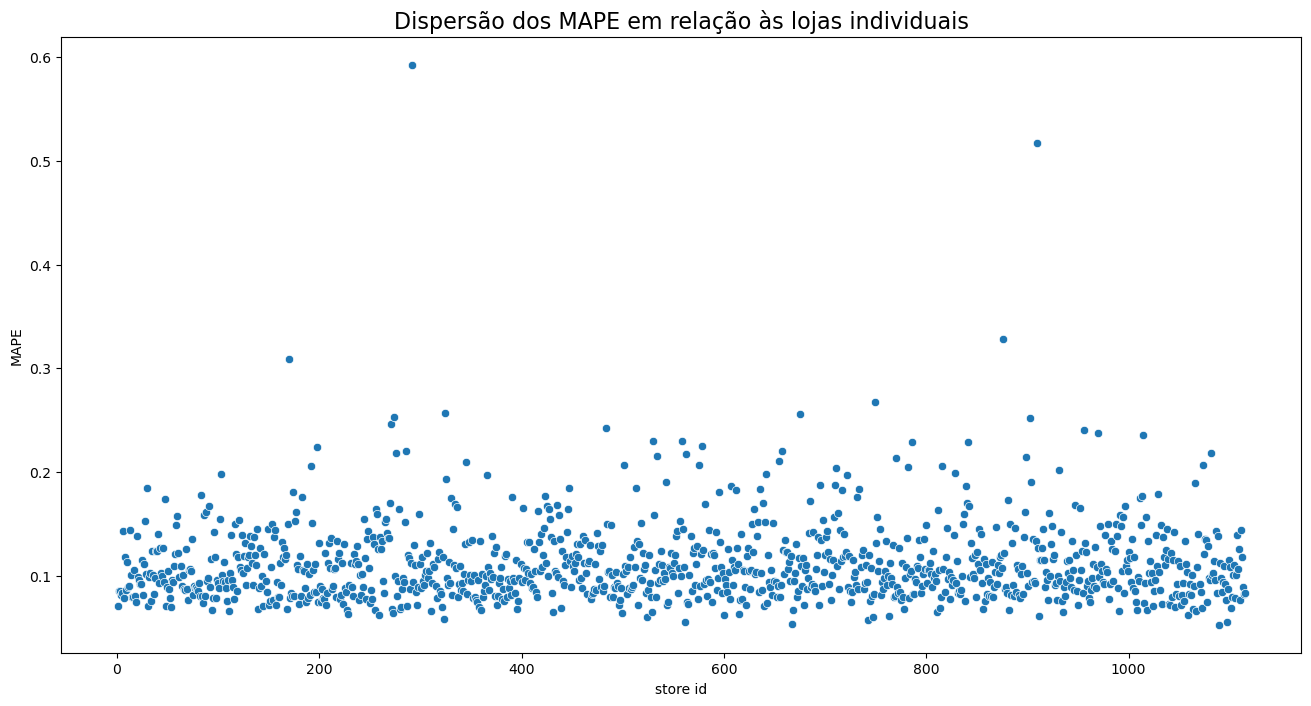

In [104]:
# Gráfico de dispersão dos erros em relação às lojas
sns.scatterplot('store', 'MAPE', data=df92).set(xlabel='store id');
plt.title('Dispersão dos MAPE em relação às lojas individuais', fontsize=16)
plt.savefig('foo.png')

## 9.2 Desempenho total

In [105]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$286,911,072.00"
1,worst_scenario,"R$286,078,167.83"
2,best_scenario,"R$287,743,976.35"


## 9.3 Desempenho do modelo

In [106]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

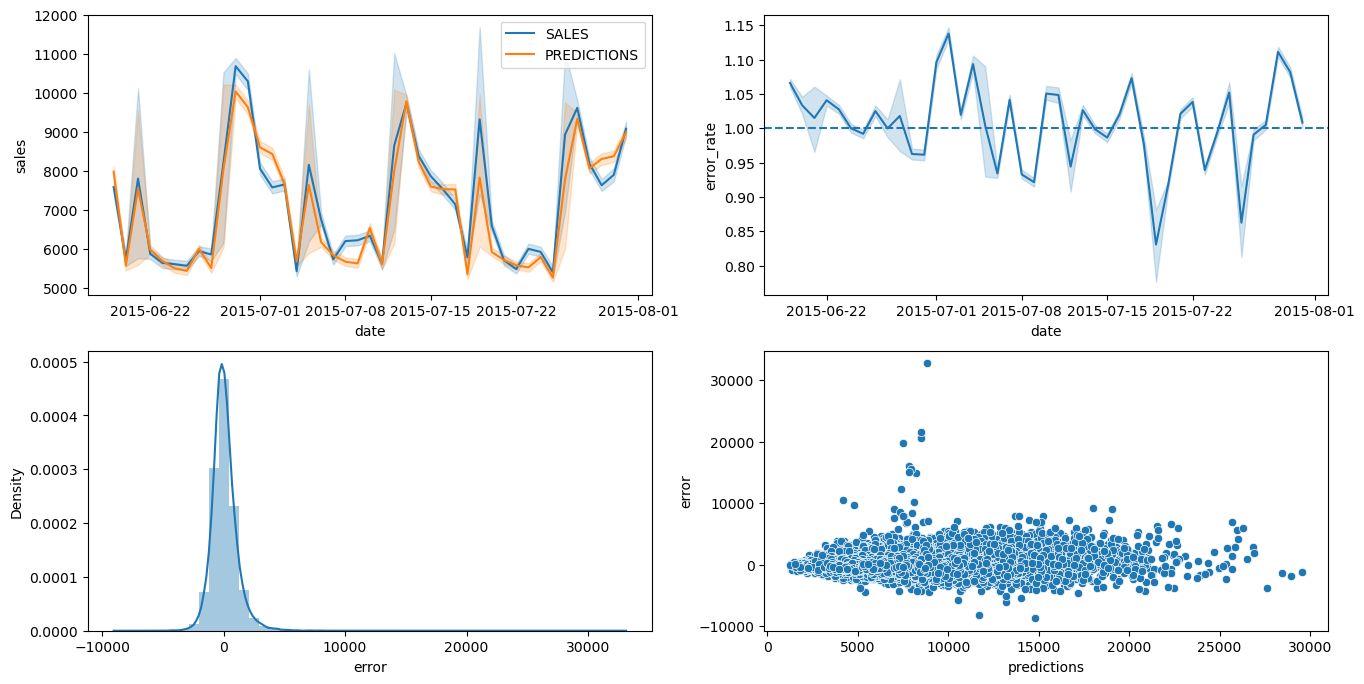

In [107]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error'])

plt.show()

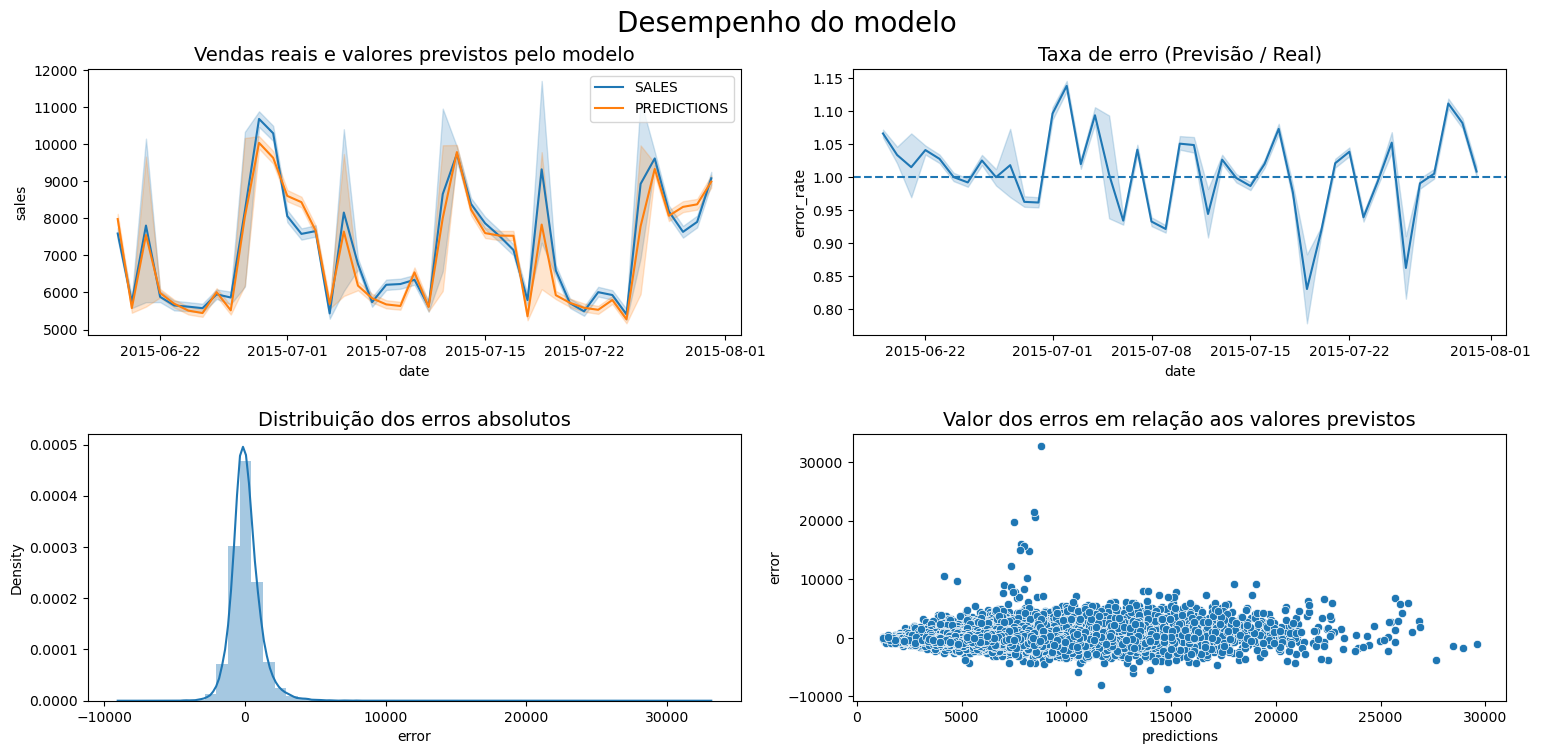

In [108]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.tight_layout(pad=5.0)
fig.suptitle('Desempenho do modelo', fontsize=20)

# plt.subplot(2, 2, 1)
sns.lineplot(ax=ax1, x='date', y='sales', data=df9, label='SALES')
sns.lineplot(ax=ax1, x='date', y='predictions', data=df9, label='PREDICTIONS')
ax1.set_title('Vendas reais e valores previstos pelo modelo', fontsize=14)

# plt.subplot(2, 2, 2)
sns.lineplot(ax=ax2, x='date', y='error_rate', data=df9)
ax2.axhline(y=1, linestyle='--')
ax2.set_title('Taxa de erro (Previsão / Real)', fontsize=14)

# plt.subplot(2, 2, 3)
sns.distplot(ax=ax3, a=df9['error'])
ax3.set_title('Distribuição dos erros absolutos', fontsize=14)

# plt.subplot(2, 2, 4)
sns.scatterplot(ax=ax4, x=df9['predictions'], y=df9['error'])
ax4.set_title('Valor dos erros em relação aos valores previstos', fontsize=14)

plt.savefig('model_performance.png')
plt.show()

# 10.0 IMPLANTAÇÃO DO MODELO PARA PRODUÇÃO

## 10.1 Classe Rossmann

In [109]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path='/home/lucas/Desktop/repos/ds-em-producao/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
        
    def data_cleaning(self, df1): 
        ## Renomeando as colunas
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        # renomeando
        df1.columns = cols_new

        ## Tipos de dados
        df1['date'] = pd.to_datetime(df1['date'])

        ## Preenchendo NAs
          
        # coluna competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # coluna competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # coluna competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        # coluna promo2_since_week           
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # coluna promo2_since_year           
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # coluna promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        
        ## Alterando os tipos dos dados
        # colunas competiton_open_since_month/year
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        # colunas promo2_since_week/year
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1 


    def feature_engineering(self, df2):
        # coluna year
        df2['year'] = df2['date'].dt.year

        # coluna month
        df2['month'] = df2['date'].dt.month

        # coluna day
        df2['day'] = df2['date'].dt.day

        # coluna week_of_year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # coluna year_week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # colunas_competition
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # coluna promo_since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # coluna assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # coluna state_holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


        ## Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## Seleção das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2


    def data_preparation(self, df5):
        ## Rescaling 
        # coluna competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values )
    
        # coluna competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values )

        # coluna promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)
        
        # coluna year
        df5['year'] = self.year_scaler.transform(df5[['year']].values)

        ### Encoding
        # coluna state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # coluna store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'])

        # coluna assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        
        ### Transformação de natureza
        # colunas day_of_week_sin/cos
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

        # colunas month_sin/cos
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

        # colunas day_sin/cos
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

        # colunas week_of_yearsin/cos
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))
        
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        # previsão
        pred = model.predict(test_data)
        
        # adicionando a predição nos dados originais
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2 API Handler

In [110]:
# import pickle
# import pandas as pd
# from flask             import Flask, request, Response
# from rossmann.Rossmann import Rossmann

# # carregando o modelo
# model = pickle.load(open('/home/lucas/Desktop/repos/ds-em-producao/webapp/model/model_rossmann.pkl', 'rb'))

# # inicializando API
# app = Flask(__name__)

# @app.route('/rossmann/predict', methods=['POST'])
# def rossmann_predict():
#     test_json = request.get_json()
   
#     if test_json: # há dados
#         if isinstance(test_json, dict): # exemplo único
#             test_raw = pd.DataFrame(test_json, index=[0])
            
#         else: # exemplos múltiplos
#             test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
#         # Instanciando a classe Rossmann
#         pipeline = Rossmann()
        
#         # limpeza dos dados
#         df1 = pipeline.data_cleaning(test_raw)
        
#         # feature engineering
#         df2 = pipeline.feature_engineering(df1)
        
#         # preparação dos dados
#         df3 = pipeline.data_preparation(df2)
        
#         # previsão
#         df_response = pipeline.get_prediction(model, test_raw, df3)
        
#         return df_response
        
        
#     else:
#         return Reponse('{}', status=200, mimetype='application/json')

# if __name__ == '__main__':
#     app.run('0.0.0.0')

## 10.3 API Tester

In [111]:
# carregando os dados de teste
df10 = pd.read_csv('/home/lucas/Desktop/repos/ds-em-producao/data/test.csv')
df_store_raw = pd.read_csv('/home/lucas/Desktop/repos/ds-em-producao/data/store.csv')

# mesclando os dados de teste com os dados das lojas
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# escolhendo lojas para fazer a previsão
# df_test = df_test[df_test['Store'].isin([20, 23, 22])]

# removendo os dias em que as lojas estão fechadas
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

# convertendo DataFrame para json
data = json.dumps(df_test.to_dict(orient='records'))

# Chamada da API
# url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-test-lr.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'} 
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


## 10.4 Tabela final de previsões de vendas por loja

In [112]:
# Convertendo o json para DataFrame
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

# Selecionando as colunas de interesse
d2 = d1[['store', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
         'competition_open_since_year', 'prediction']]

# Aplicando pivot_table para agregar os dados por loja
d2 = pd.pivot_table(d2, index='store', aggfunc={'store_type': statistics.mode, 'assortment': statistics.mode,
                                                'competition_distance': np.mean,
                                                'competition_open_since_month': np.mean,
                                                'competition_open_since_year': np.mean,
                                                'prediction': np.sum}).reset_index()

# Reorganizando as colunas
d2 = d2[['store', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 
         'competition_open_since_year', 'prediction']]

# Ajustando os tipos de dados
d2['competition_distance'] = d3['competition_distance'].astype(int)
d2['competition_open_since_month'] = d3['competition_open_since_month'].astype(int)

# Ordenando as lojas por previsão de vendas em ordem decrescente
d2 = d2.sort_values(by='prediction', ascending=False)

# Salvando a tabela em um arquivo .csv
d2.to_csv('data/predicted_sales.csv')